In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from seaborn import set_style
import statsmodels.tsa.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima
set_style("whitegrid")

In [165]:
stock_symbols = ['GOOG','MSFT','AMZN','NVDA','AAPL']

In [166]:
df = [pd.read_csv(f'/home/hirak/Desktop/Erdos/SIGNS_2024/stock_data/{symbol}/stock_price.csv') for symbol in stock_symbols]
df_ss = [pd.read_csv(f'/home/hirak/Desktop/Erdos/SIGNS_2024/stock_news_sentiment_scores/2011-2024/stock_news_sentiment_analysis_results_{symbol}.csv') for symbol in stock_symbols]
df_gss = [pd.read_csv(f'/home/hirak/Desktop/Erdos/SIGNS_2024/news_sentiment_scores/2000-2024/sentiment_analysis_results_{symbol}.csv') for symbol in stock_symbols]

In [4]:
len(df), len(df_ss), len(df_gss)

(5, 5, 5)

In [167]:
for i in range(len(df)):
    df[i]['Date'] = pd.to_datetime(df[i]['Date'], utc=True).dt.date
    # df[i]['Date'].index = pd.DatetimeIndex(df[i]['Date'].index).to_period('M')
    df_ss[i]['Date'] = pd.to_datetime(df_ss[i]['Date'], utc=True).dt.date
    # df_ss[i]['Date'].index = pd.DatetimeIndex(df_ss[i]['Date'].index).to_period('M')
    df_gss[i]['Date'] = pd.to_datetime(df_gss[i]['Date'], utc=True).dt.date
    print(len(df[i]), len(df_ss[i]), len(df_gss[i]))

3457 1663 1765
3457 1626 1501
3457 1979 2970
3457 1486 831
3457 1997 917


In [168]:
df = [df[i].drop_duplicates(subset=['Date'], keep='first', inplace=False) for i in range(len(df))]
df_ss = [df_ss[i].drop_duplicates(subset=['Date'], keep='first', inplace=False) for i in range(len(df))]
df_gss = [df_gss[i].drop_duplicates(subset=['Date'], keep='first', inplace=False) for i in range(len(df))]
for i in range(len(df)):
    print(len(df[i]), len(df_ss[i]), len(df_gss[i]))

3457 1663 1765
3457 1626 1501
3457 1979 2970
3457 1486 831
3457 1997 917


In [169]:
# Merge on the 'date' column, only take common days from both dataframes
df = [pd.merge(df[i], df_gss[i], on='Date', how='outer') for i in range(len(df))]  # 'how' can be 'inner', 'outer', 'left', or 'right'
df = [df[i].drop(['Ticker'],axis=1) for i in range(len(df))]
for i in range(len(df)):
    print(len(df[i]))

4276
4242
4916
3865
3885


In [170]:
df = [df[i].dropna(subset=['Open']) for i in range(len(df))]
df = [df[i].fillna(0.0) for i in range(len(df))]

In [9]:
for i in range(len(df)):
    print(len(df[i]))

3457
3457
3457
3457
3457


In [171]:
df[0].head()

Date       Open       High        Low      Close       Volume  \
483  2011-01-03  14.819920  15.046263  14.819920  15.015455   94962614.0   
484  2011-01-04  15.047010  15.060922  14.910357  14.960049   73253547.0   
485  2011-01-05  14.909116  15.164031  14.908619  15.132727  101671667.0   
486  2011-01-06  15.172727  15.365282  15.157075  15.242792   82620526.0   
487  2011-01-07  15.302670  15.360810  15.159063  15.315838   84363033.0   

     Dividends  Stock Splits  weighted positive sentiment score  \
483        0.0           0.0                              0.000   
484        0.0           0.0                              0.000   
485        0.0           0.0                              0.154   
486        0.0           0.0                              0.000   
487        0.0           0.0                              0.000   

     weighted negative sentiment score  weighted neutral sentiment score  \
483                              0.000                             0.000   
484                              0.000                             0.000   
485                              0.248                             0.598   
486                              0.000                             0.000   
487                              0.000                             0.000   

     weighted compound sentiment score  
483                             0.0000  
484                             0.0000  
485                            -0.2732  
486                             0.0000  
487                             0.0000

In [172]:
df_close = [df[i][["Close"]].copy() for i in range(len(df))]
df_close_sma = [df_close[i].rolling(window=14).mean() for i in range(len(df))]
df_sma_gss = [df[i][["weighted compound sentiment score"]].copy() for i in range(len(df))]
df_vol = [df[i][["Volume"]].copy() for i in range(len(df))]

In [173]:
df_close = [df_close[i][14:] for i in range(len(df))]
df_close = [df_close[i].reset_index() for i in range(len(df))]
df_close_sma = [df_close_sma[i][14:] for i in range(len(df))]
df_close_sma = [df_close_sma[i].reset_index() for i in range(len(df))]
df_sma_gss = [df_sma_gss[i][14:] for i in range(len(df))]
df_sma_gss = [df_sma_gss[i].reset_index() for i in range(len(df))]
df_vol = [df_vol[i][14:] for i in range(len(df))]
df_vol = [df_vol[i].reset_index() for i in range(len(df))]


In [13]:
df_close = [df_close[i].drop(['index'],axis=1) for i in range(len(df_close))]
df_close_sma = [df_close_sma[i].drop(['index'],axis=1) for i in range(len(df_close_sma))]
df_sma_gss = [df_sma_gss[i].drop(['index'],axis=1) for i in range(len(df_sma_gss))]

In [174]:
for i in range(len(df)):
    print(len(df_close[i]), len(df_close_sma[i]), len(df_vol[i]), len(df_sma_gss[i]))


3443 3443 3443 3443
3443 3443 3443 3443
3443 3443 3443 3443
3443 3443 3443 3443
3443 3443 3443 3443


In [15]:
df_close[0]

Close
0      15.182666
1      15.402054
2      15.317329
3      15.324534
4      14.931973
...          ...
3438  163.070007
3439  163.639999
3440  162.990005
3441  163.830002
3442  165.289993

[3443 rows x 1 columns]

In [92]:
df_close_sma[0]

Close
0      15.351314
1      15.382886
2      15.396072
3      15.401911
4      15.374492
...          ...
3438  157.468860
3439  157.900107
3440  158.228571
3441  159.078571
3442  160.203571

[3443 rows x 1 columns]

In [93]:
df_sma_gss[0]

weighted compound sentiment score
0                                0.0000
1                                0.0000
2                               -0.2732
3                                0.0000
4                                0.0000
...                                 ...
3438                             0.0000
3439                             0.0000
3440                             0.0000
3441                             0.0000
3442                             0.0000

[3443 rows x 1 columns]

In [127]:
for i in range(len(df_close_sma)):
    result = adfuller(df_close_sma[i].Close)
    print(f'ADF statistic: {result[0]}')
    print(f'p-value: {result[1]}')

ADF statistic: 0.2488004604477506
p-value: 0.9748696156176361
ADF statistic: 1.462930240860932
p-value: 0.9973820860273647
ADF statistic: -0.21707129209394604
p-value: 0.9364559368381958
ADF statistic: 4.867917664692226
p-value: 1.0
ADF statistic: 0.9608229048652772
p-value: 0.9938348937564851


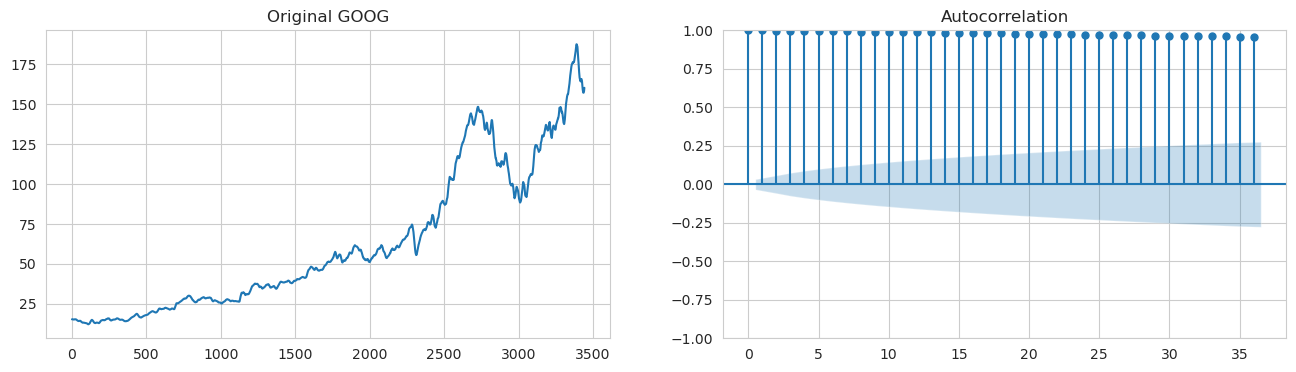

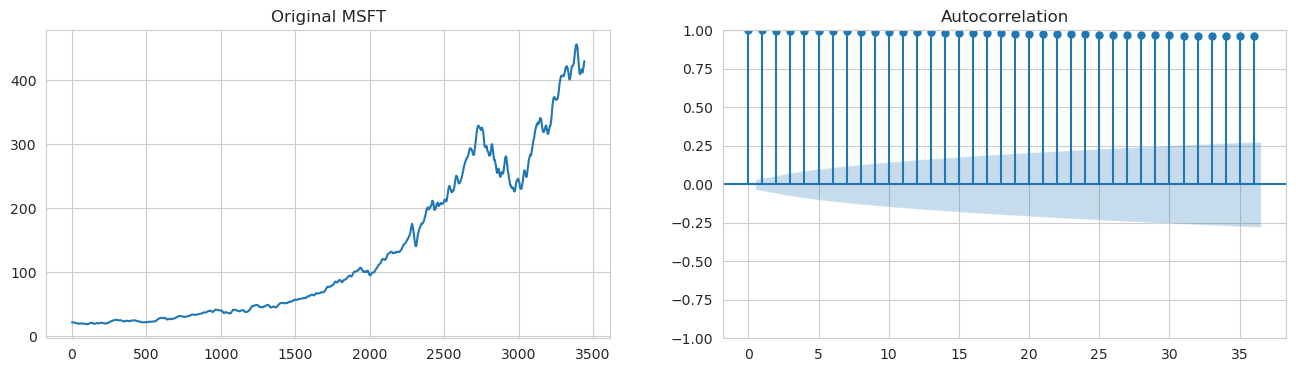

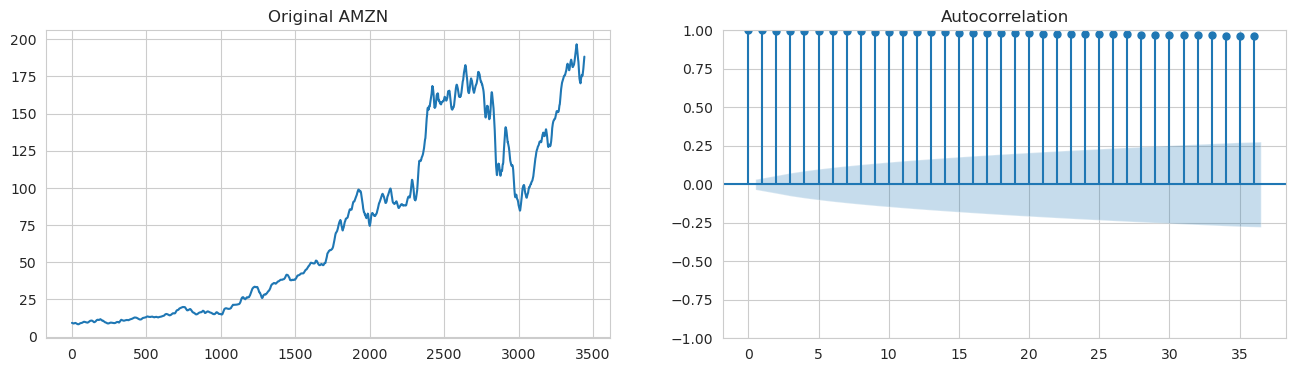

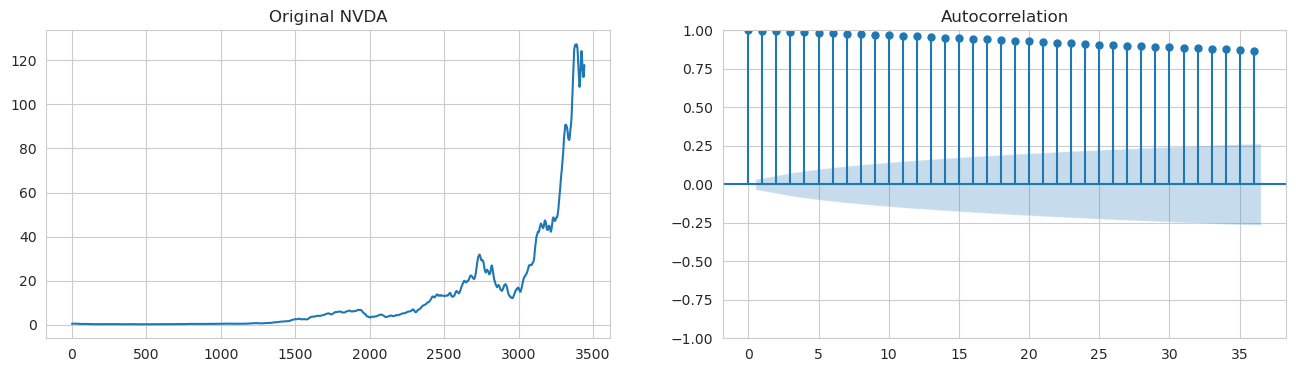

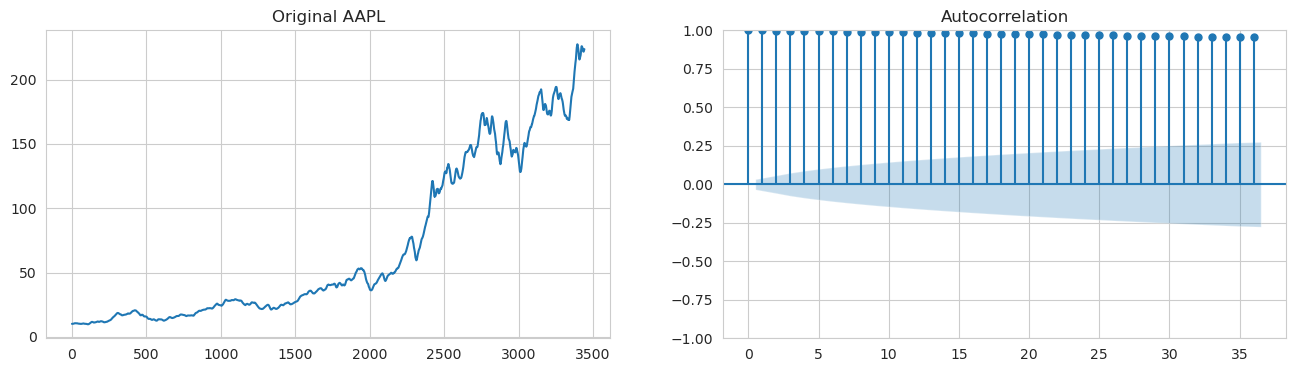

In [95]:
for i in range(len(df_close_sma)):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,4))
    ax1.plot(df_close_sma[i])
    ax1.set_title(f"Original {stock_symbols[i]}")
    plot_acf(df_close_sma[i], ax=ax2);

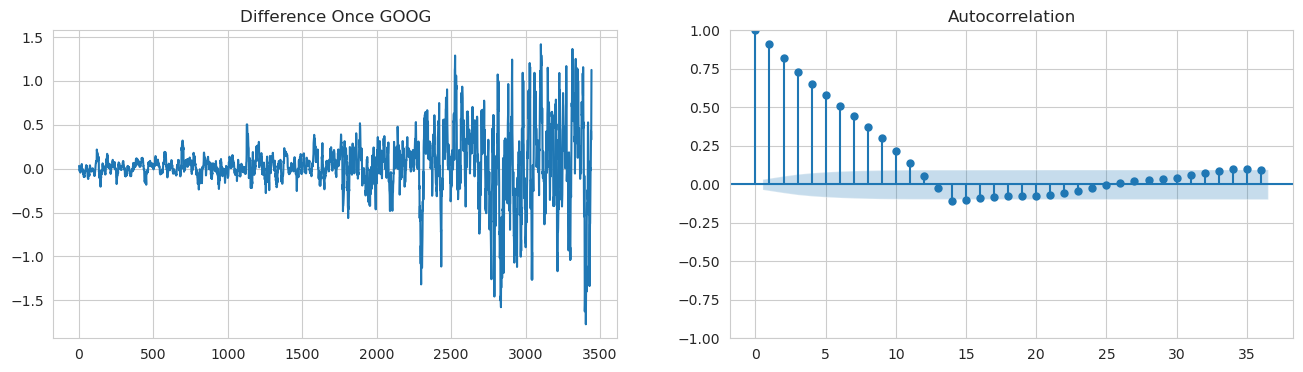

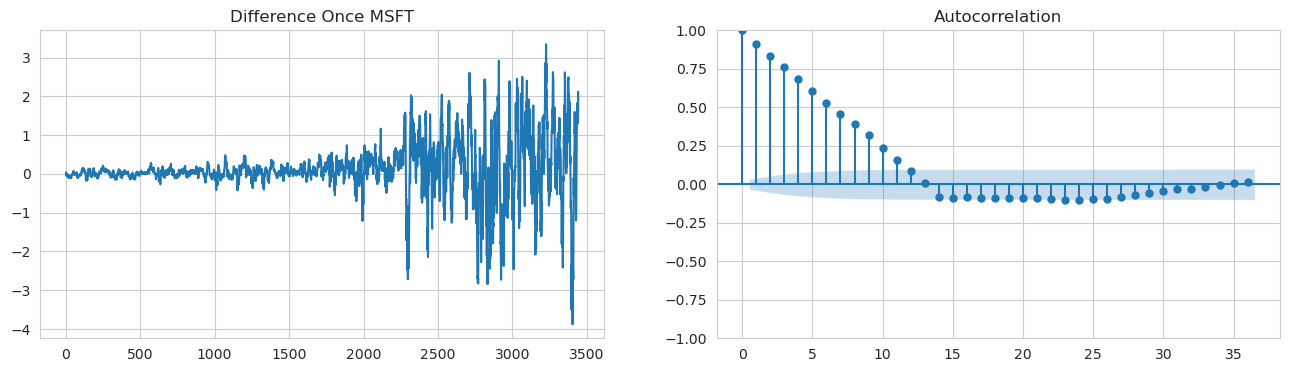

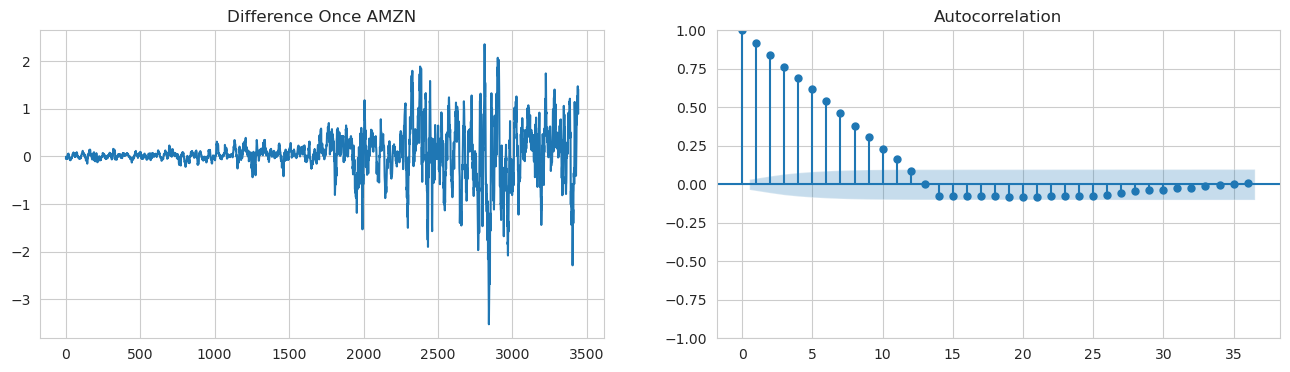

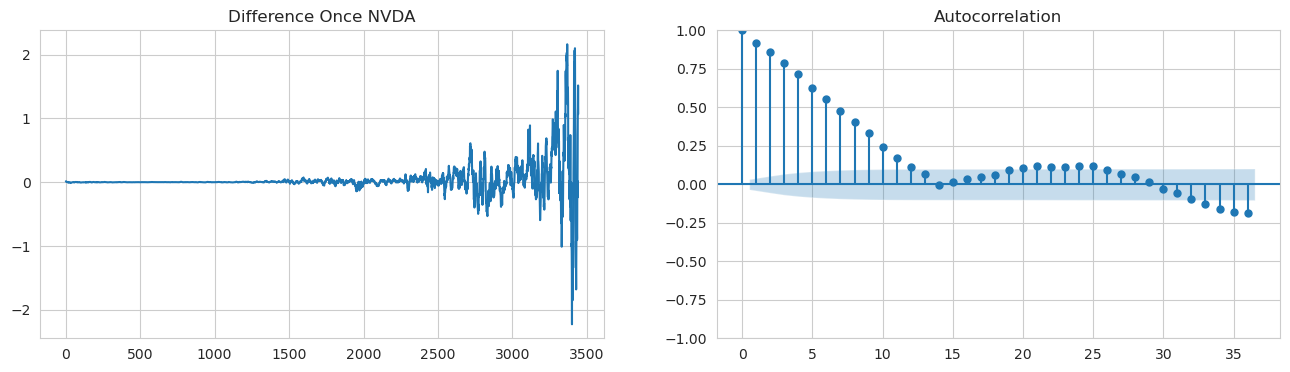

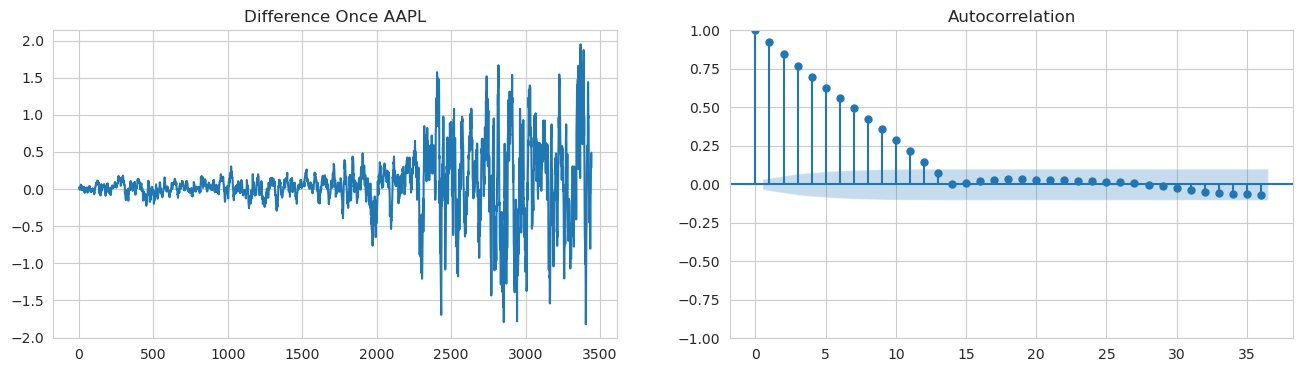

In [96]:
for i in range(len(df_close_sma)):
    diff1 = df_close_sma[i].Close.diff().dropna()
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,4))
    ax1.plot(diff1)
    ax1.set_title(f"Difference Once {stock_symbols[i]}")
    plot_acf(diff1, ax=ax2);

In [97]:
ndif = [ndiffs(df_close_sma[i], test="adf") for i in range(len(df_close_sma))]
print("ndif", ndif)

ndif [1, 1, 1, 1, 1]


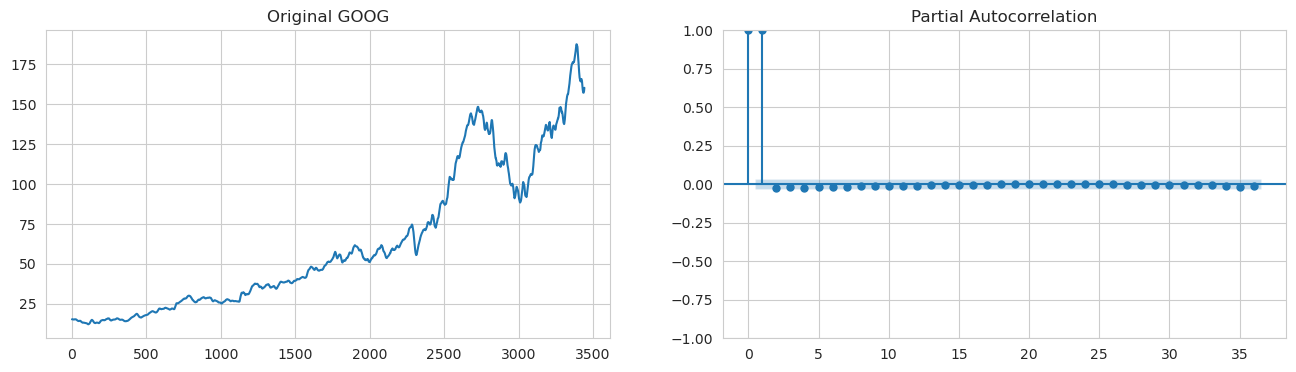

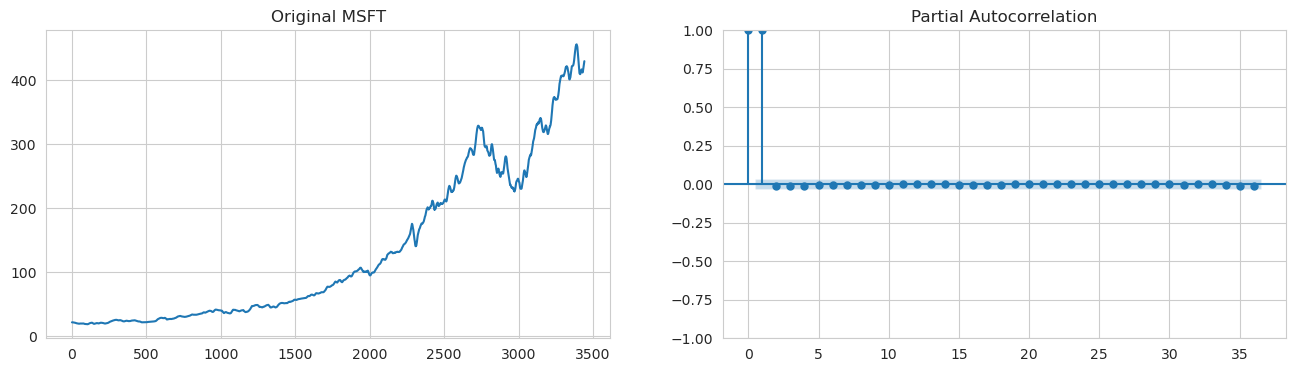

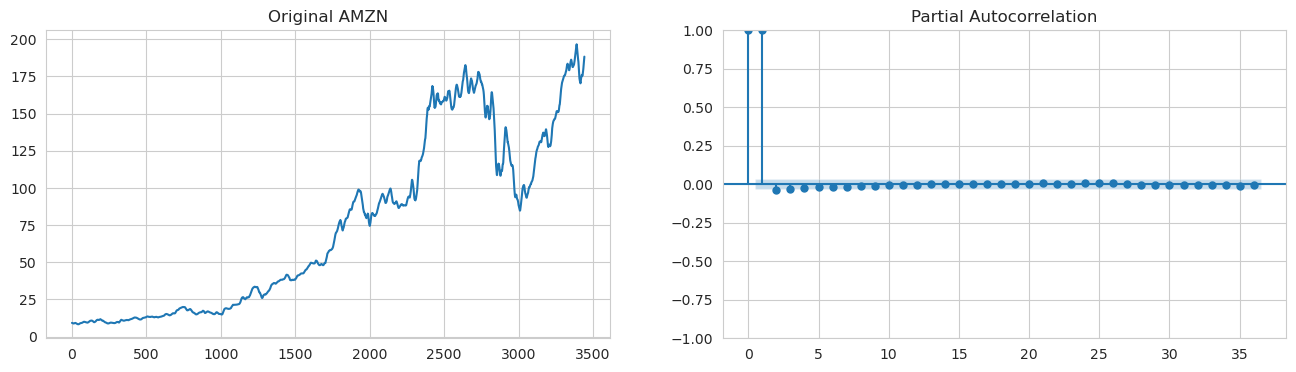

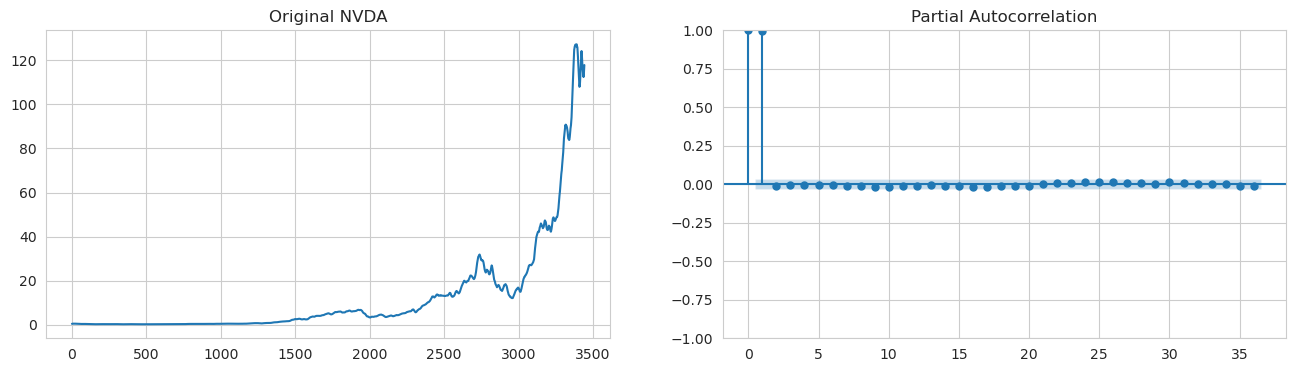

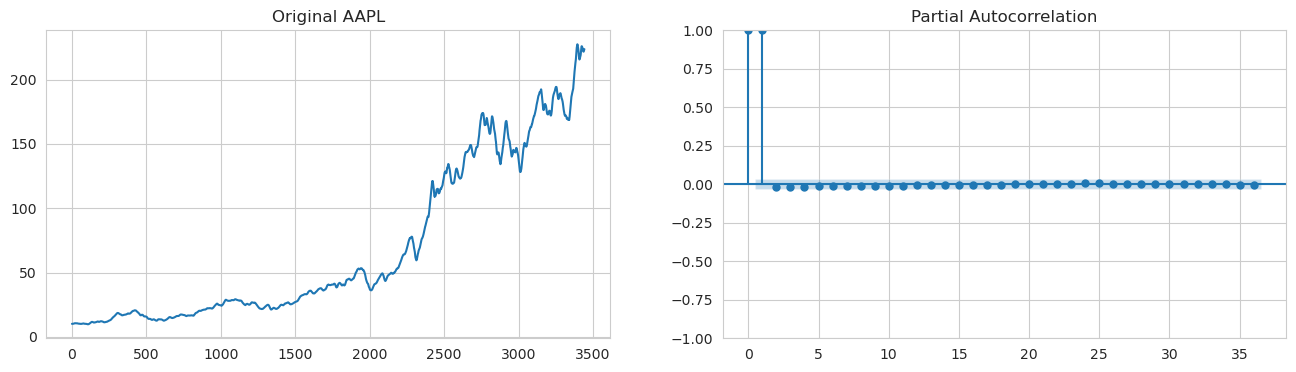

In [98]:
for i in range(len(df_close_sma)):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,4))
    ax1.plot(df_close_sma[i].Close)
    ax1.set_title(f"Original {stock_symbols[i]}")
    plot_pacf(df_close_sma[i].Close, ax=ax2);

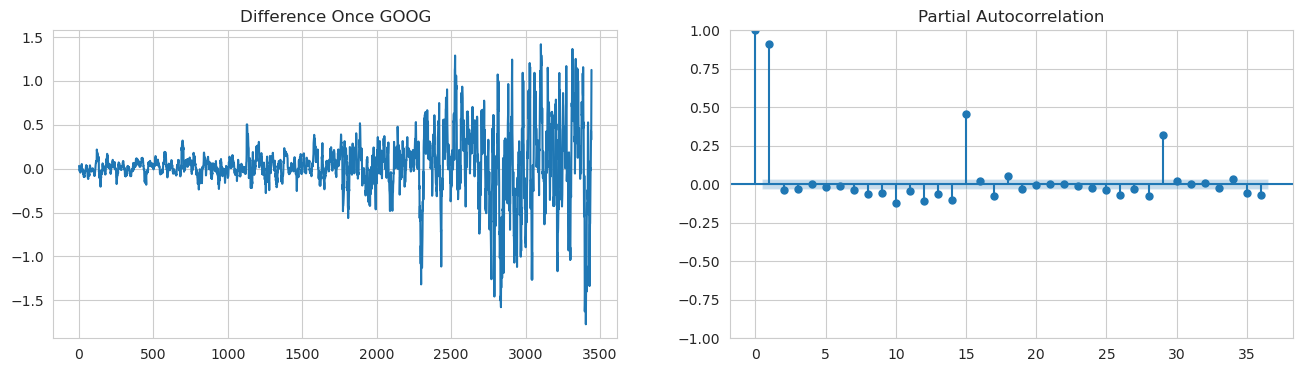

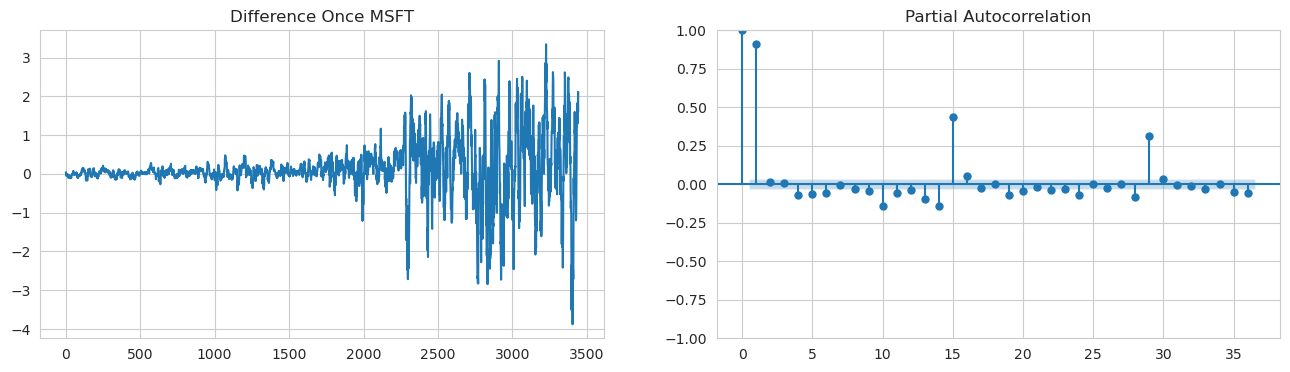

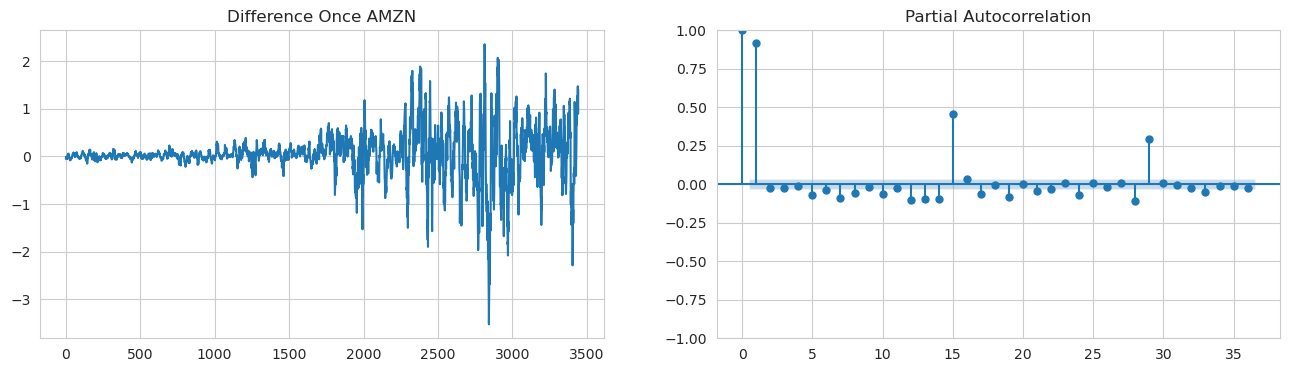

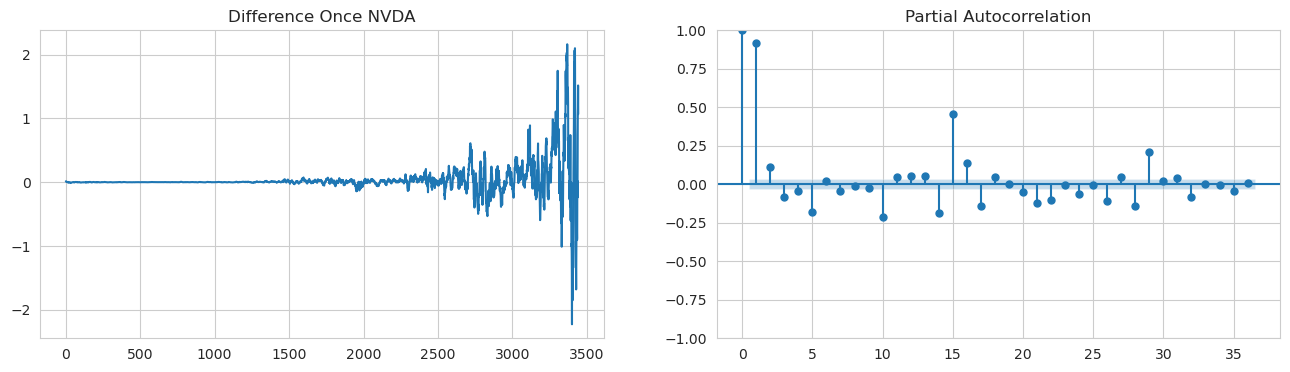

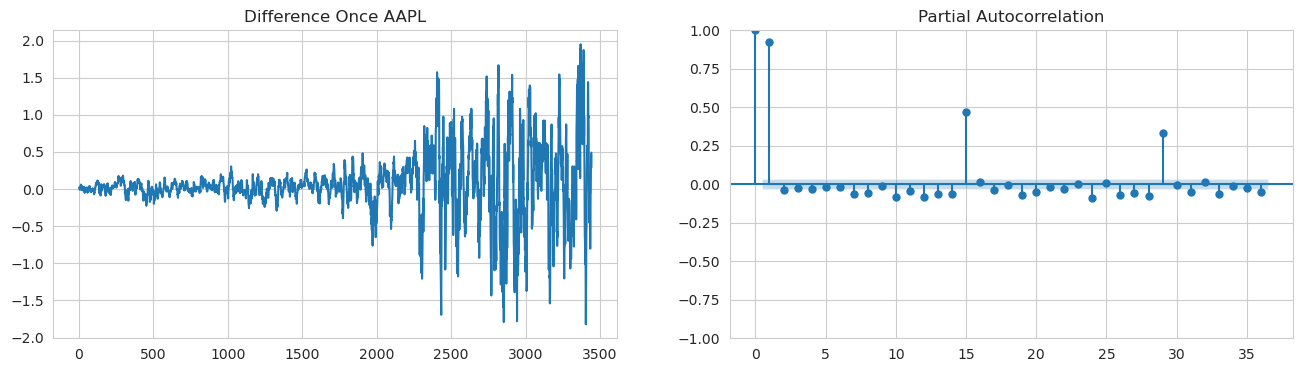

In [99]:
for i in range(len(df_close_sma)):
    diff1 = df_close_sma[i].Close.diff().dropna()

    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,4))
    ax1.plot(diff1)
    ax1.set_title(f"Difference Once {stock_symbols[i]}")
    plot_pacf(diff1, ax=ax2);

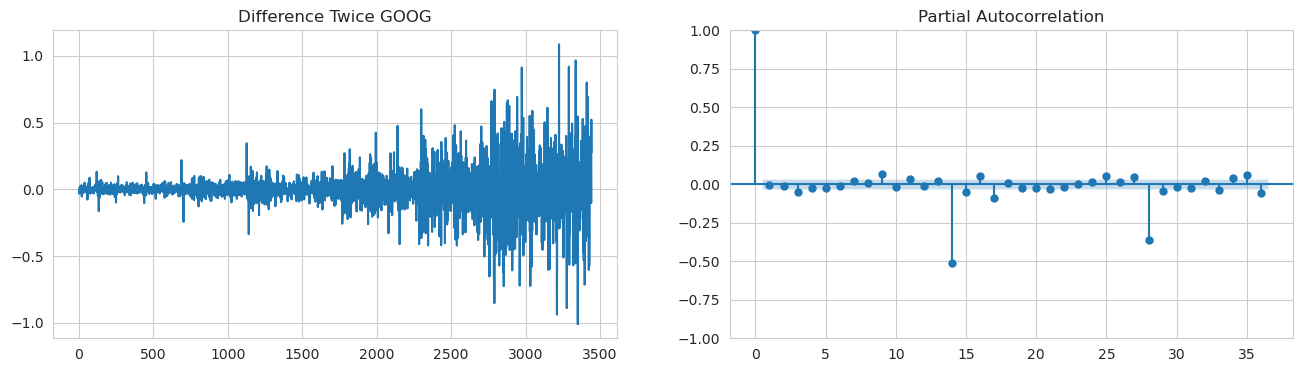

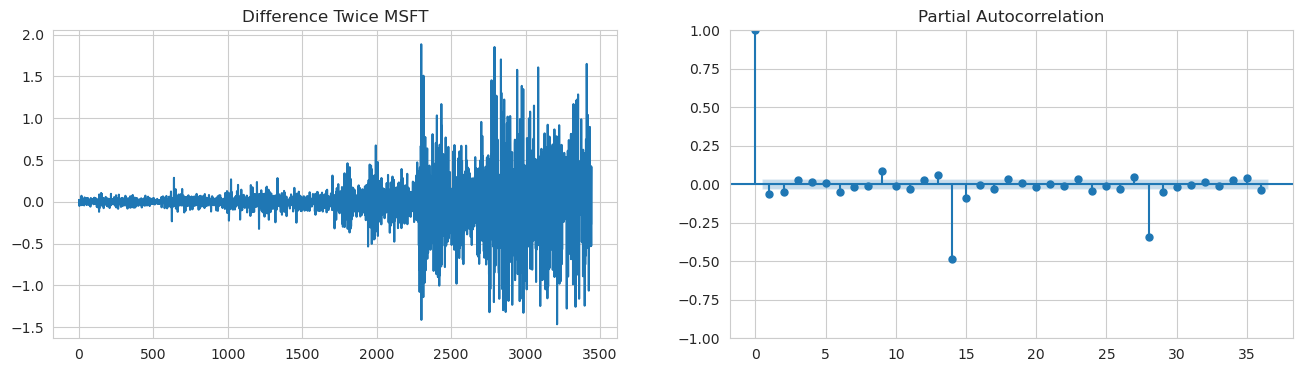

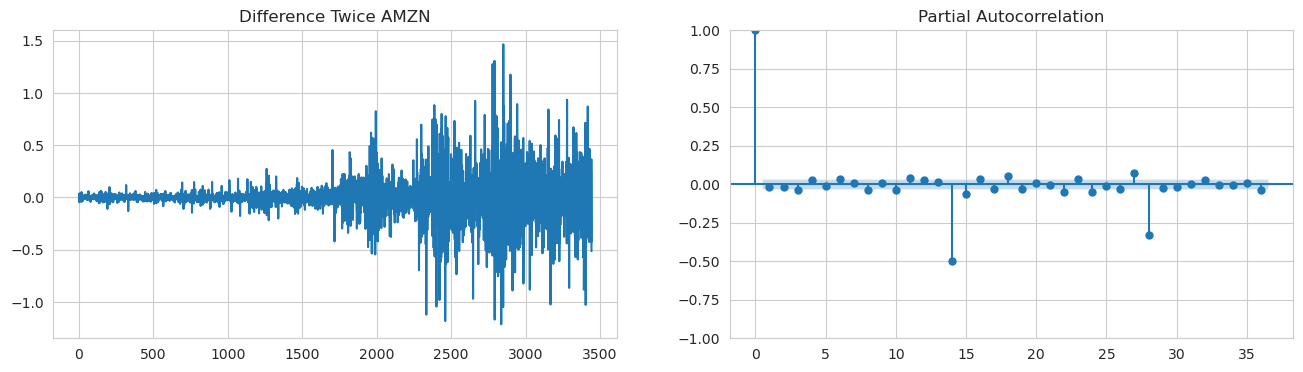

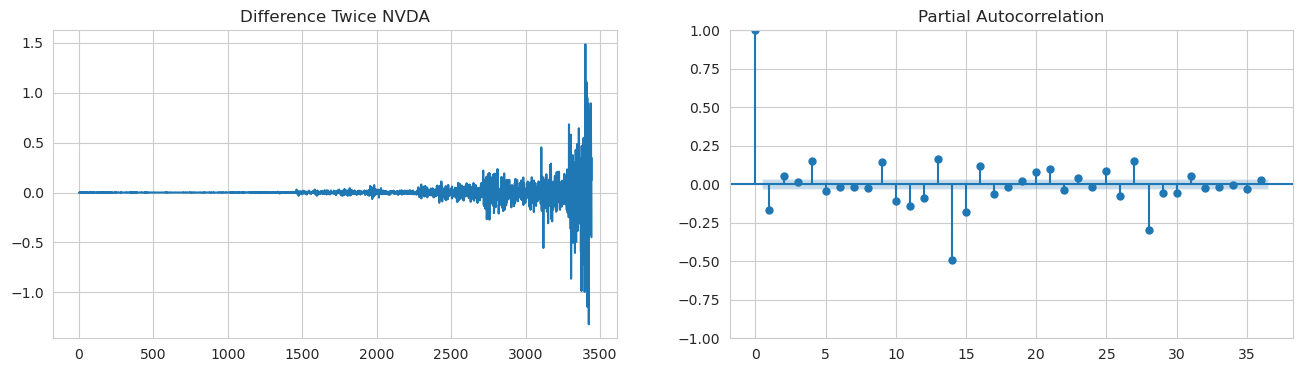

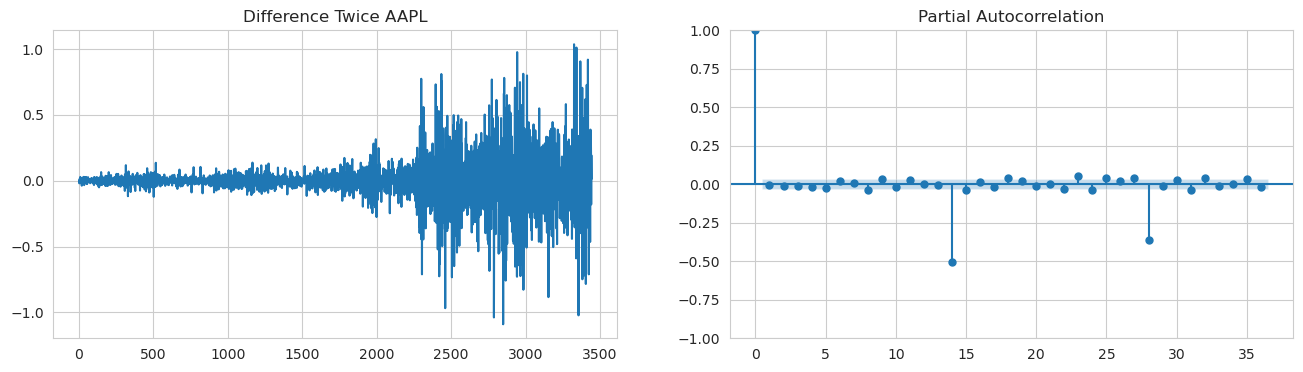

In [100]:
for i in range(len(df_close_sma)):
    diff2 = df_close_sma[i].Close.diff().diff().dropna()
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,4))
    ax1.plot(diff2)
    ax1.set_title(f"Difference Twice {stock_symbols[i]}")
    plot_pacf(diff2, ax=ax2);

In [71]:
# orderr = auto_arima(df[0].Close, trace=True).get_params().get("order")
# print(orderr)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12156.413, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12154.912, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12154.797, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12157.727, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12156.168, Time=2.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12155.779, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12150.697, Time=2.01 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=12150.076, Time=2.48 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=12149.251, Time=0.81 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=12151.027, Time=0.97 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=12149.240, Time=5.65 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=12151.053, Time=5.92 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=12151.368, Time=4.06 sec
 ARIMA(0,1,5)(0,0,0)[0] i

In [129]:
arima_order = {}
for i in range(len(df_close_sma)):
    print(f"Stock name: {stock_symbols[i]}")
    #arima_order[i] = auto_arima(df_close_sma[i].Close, trace=True).get_params().get("order")
    arima_order[i] = auto_arima(df_close_sma[i].Close, trace=True, exogenous=[df_sma_gss[i]["weighted compound sentiment score"]]).get_params().get("order")
    print(f"ARIMA Order for {stock_symbols[i]}: {arima_order[i]}")

Stock name: GOOG
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3767.204, Time=2.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2285.281, Time=0.71 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3761.564, Time=1.48 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-641.382, Time=2.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2336.530, Time=0.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3769.184, Time=1.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2076.292, Time=2.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3765.523, Time=1.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3767.210, Time=10.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2775.371, Time=3.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3790.992, Time=3.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3766.048, Time=0.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3767.470, Time=5.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3769.321, Time=1.08 sec
 ARI

In [130]:
arima_result = {}
for i in range(len(df_close_sma)):
    model = sm.ARIMA(df_close_sma[i].Close, order=arima_order[i])
    arima_result[i] = model.fit()
    print(f"\n ARIMA Results for {stock_symbols[i]}:\n {arima_result[i].summary()}")


 ARIMA Results for GOOG:
                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3443
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1898.859
Date:                Fri, 29 Nov 2024   AIC                          -3789.718
Time:                        19:50:24   BIC                          -3765.142
Sample:                             0   HQIC                         -3780.940
                               - 3443                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8199      0.022     84.002      0.000       1.777       1.862
ar.L2         -0.8362      0.019    -43.474      0.000      -0.874      -0.799
ma.L1         -0.8713    

/home/hirak/anaconda3/envs/SIGNS_2024/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 ARIMA Results for NVDA:
                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3443
Model:                 ARIMA(5, 2, 1)   Log Likelihood                3199.367
Date:                Fri, 29 Nov 2024   AIC                          -6384.734
Time:                        19:50:34   BIC                          -6341.730
Sample:                             0   HQIC                         -6369.373
                               - 3443                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8151      0.006    142.890      0.000       0.804       0.826
ar.L2          0.1928      0.006     33.727      0.000       0.182       0.204
ar.L3         -0.0152    

In [76]:
# result.forecast(10)
# residuals = pd.DataFrame(result.resid)

In [78]:
# fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,4))
# ax1.plot(pd.DataFrame(result.resid))
# ax2.hist(pd.DataFrame(result.resid), density=True)


 ARIMA Residuals for GOOG:


 ARIMA Residuals for MSFT:


 ARIMA Residuals for AMZN:


 ARIMA Residuals for NVDA:


 ARIMA Residuals for AAPL:



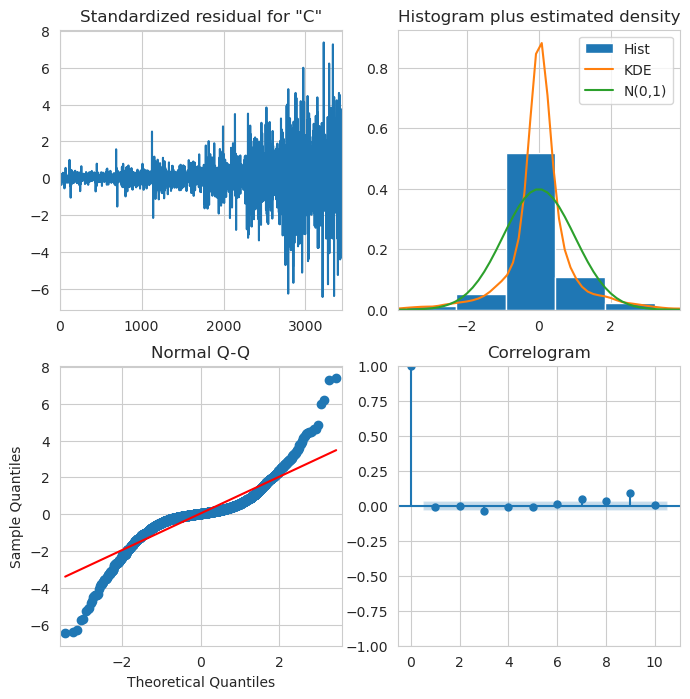

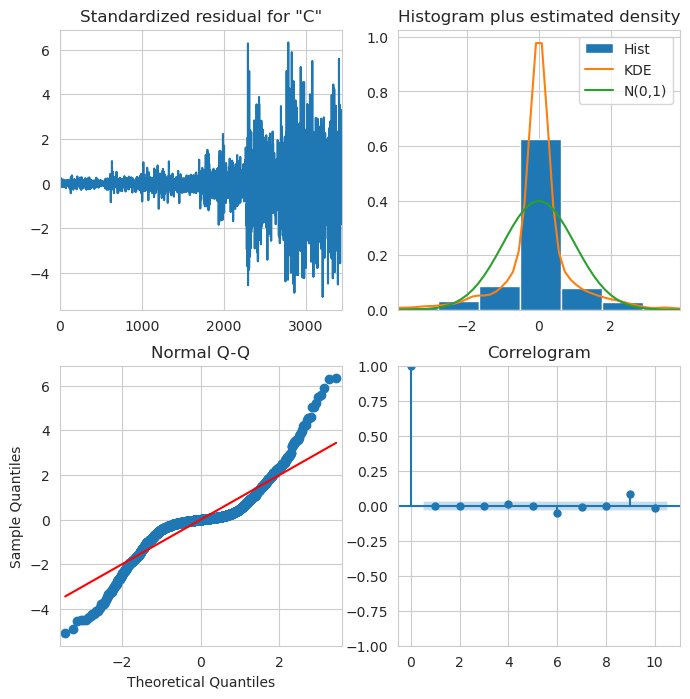

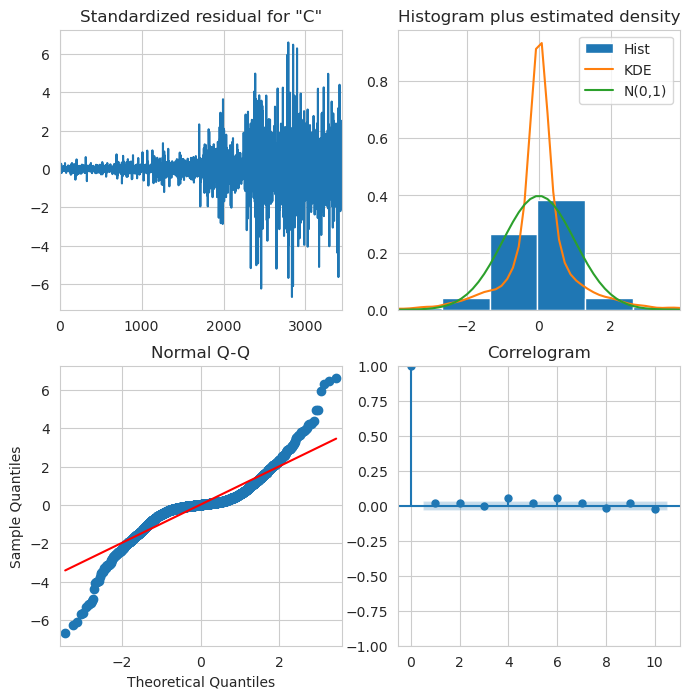

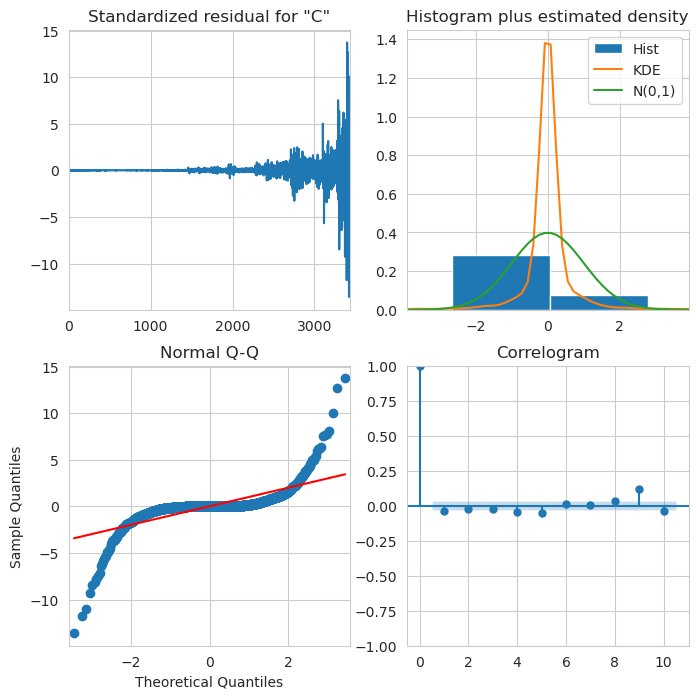

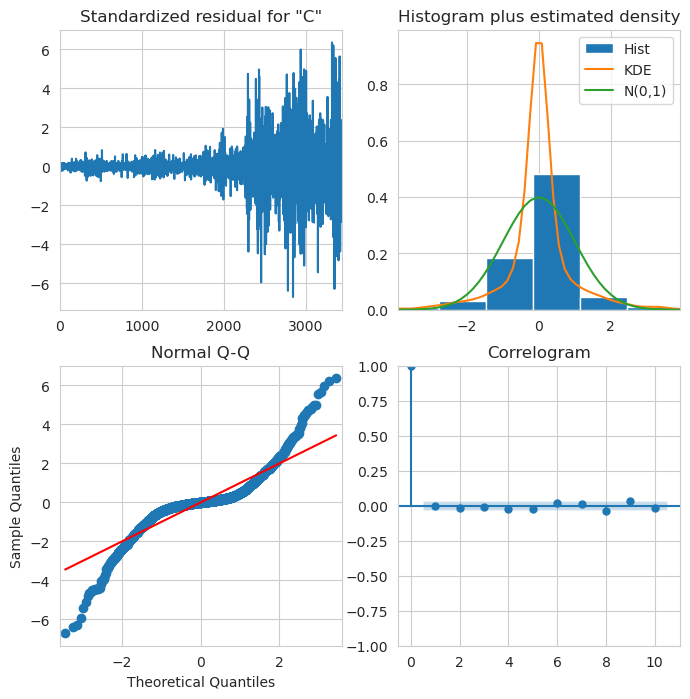

In [103]:
for i in range(len(df_close_sma)):
    arima_result[i].plot_diagnostics(figsize = (8,8))
    print(f"\n ARIMA Residuals for {stock_symbols[i]}:\n")



 Last 100 days stock Closing price for GOOG


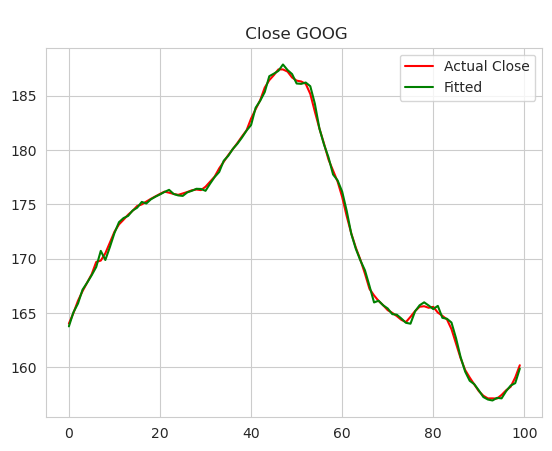


 Last 100 days stock Closing price for MSFT


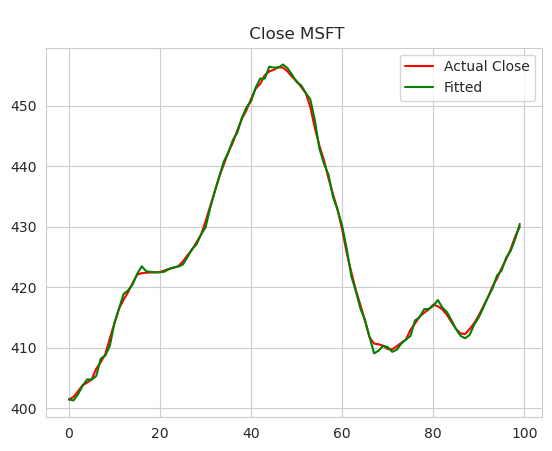


 Last 100 days stock Closing price for AMZN


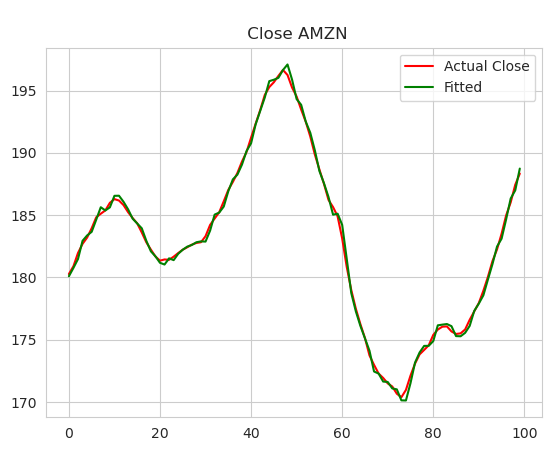


 Last 100 days stock Closing price for NVDA


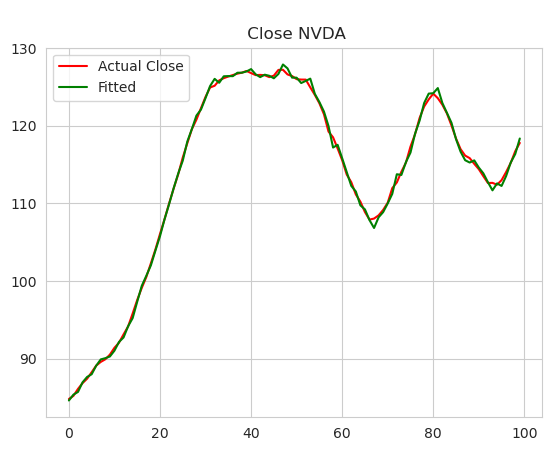


 Last 100 days stock Closing price for AAPL


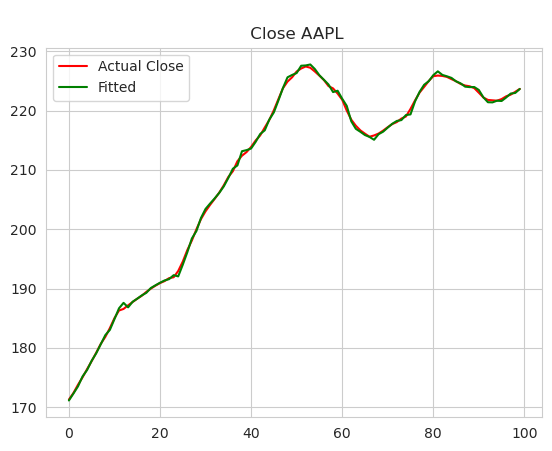

In [190]:
for i in range(len(df_close_sma)):
    print(f"\n Last 100 days stock Closing price for {stock_symbols[i]}")
    plt.plot(range(100), df_close_sma[i].Close[(len(df_close_sma[i])-100):], color='r', label='Actual Close')
    plt.plot(range(100), arima_result[i].fittedvalues[(len(df_close_sma[i])-100):], color='g', label='Fitted')
    plt.legend()
    plt.title(f"\n Close {stock_symbols[i]}")
    plt.show()

In [175]:
train = {}
test = {}
train_vol = {}
test_vol = {}
train_gss = {}
test_gss = {}
for i in range(len(df_close_sma)):
    n = 0
    n = int(len(df_close_sma[i])*0.95)
    train[i] = df_close_sma[i][:n]
    test[i] = df_close_sma[i][n:]
    print("sma",len(train[i]), len(test[i]))
for i in range(len(df_vol)):
    n = 0
    n = int(len(df_vol[i])*0.95)
    train_vol[i] = df_vol[i][:n]
    test_vol[i] = df_vol[i][n:]
    print("vol",len(train_vol[i]), len(test_vol[i]))
for i in range(len(df_sma_gss)):
    n = 0
    n = int(len(df_sma_gss[i])*0.95)
    train_gss[i] = df_sma_gss[i][:n]
    test_gss[i] = df_sma_gss[i][n:]
    print("gss",len(train_gss[i]), len(test_gss[i]))

sma 3270 173
sma 3270 173
sma 3270 173
sma 3270 173
sma 3270 173
vol 3270 173
vol 3270 173
vol 3270 173
vol 3270 173
vol 3270 173
gss 3270 173
gss 3270 173
gss 3270 173
gss 3270 173
gss 3270 173


In [17]:
for i in range(len(df_close_sma)):
    result = adfuller(train[i].Close.dropna())
    print(f"For {stock_symbols[i]}")
    print(f'ADF statistic: {result[0]}')
    print(f'p-value: {result[1]}')

For GOOG
ADF statistic: 0.42072283483248085
p-value: 0.9822535768095777
For MSFT
ADF statistic: 1.7050298993146094
p-value: 0.9981408259427789
For AMZN
ADF statistic: -0.5687811612835565
p-value: 0.877881333008081
For NVDA
ADF statistic: 3.2937338279716997
p-value: 1.0
For AAPL
ADF statistic: 0.8535144942900784
p-value: 0.9924526787048981


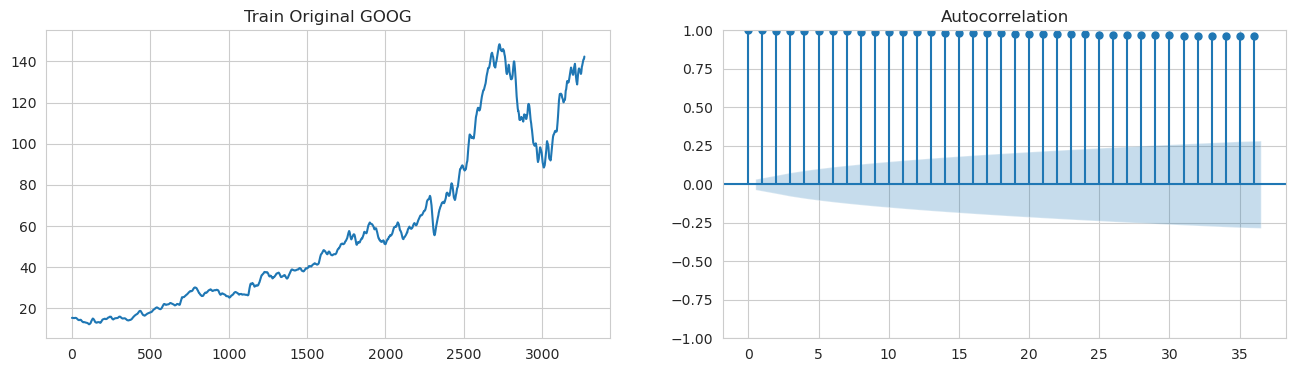

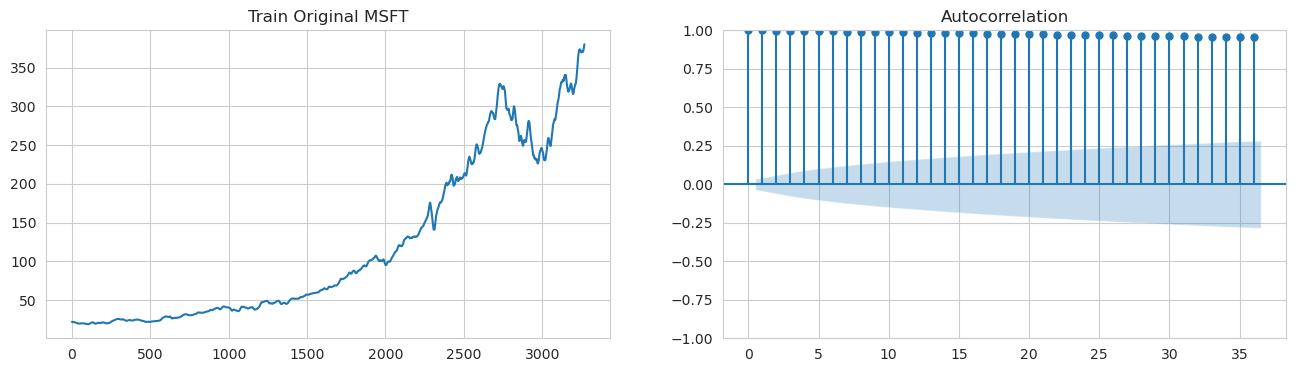

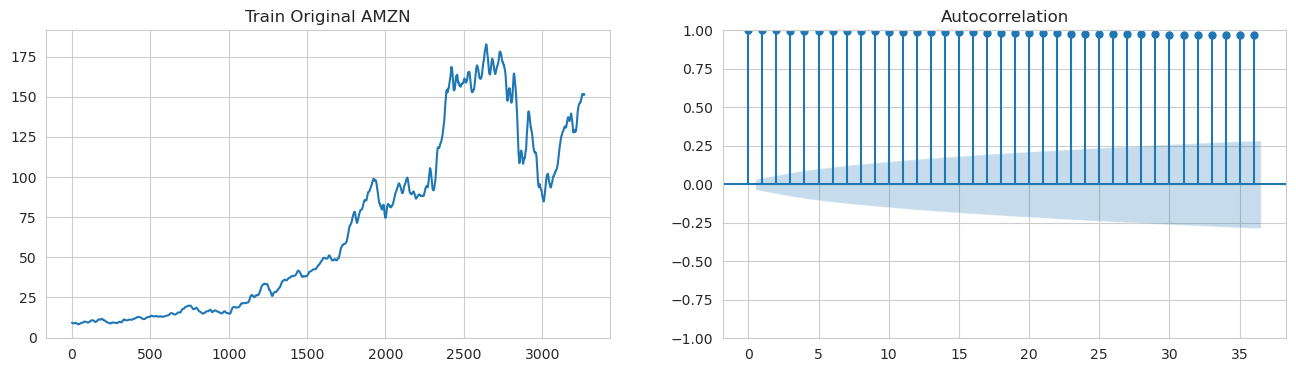

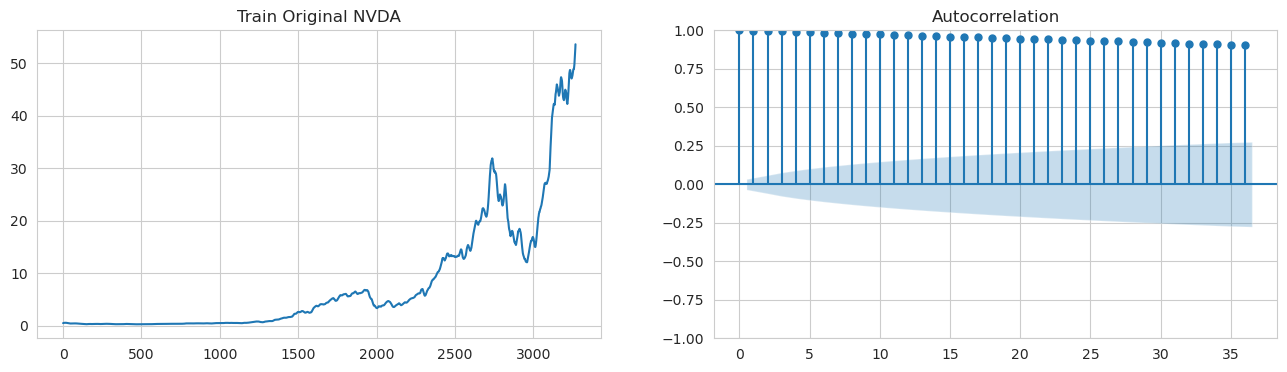

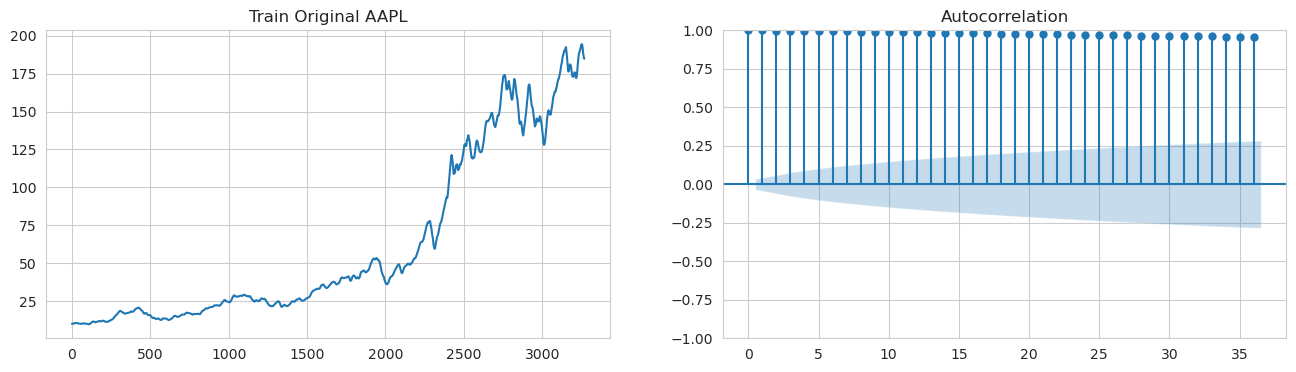

In [18]:
for i in range(len(train)):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,4))
    ax1.plot(train[i].Close)
    ax1.set_title(f"Train Original {stock_symbols[i]}")
    plot_acf(train[i].Close, ax=ax2);

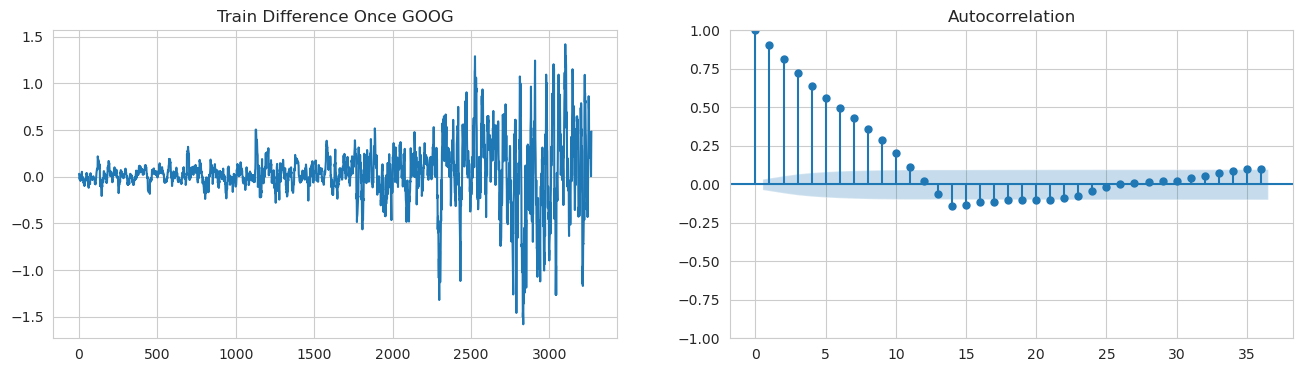

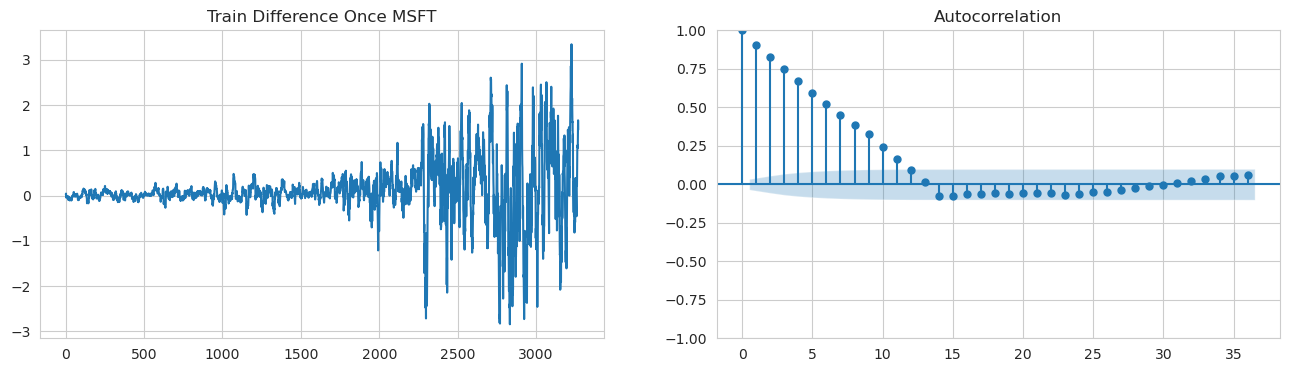

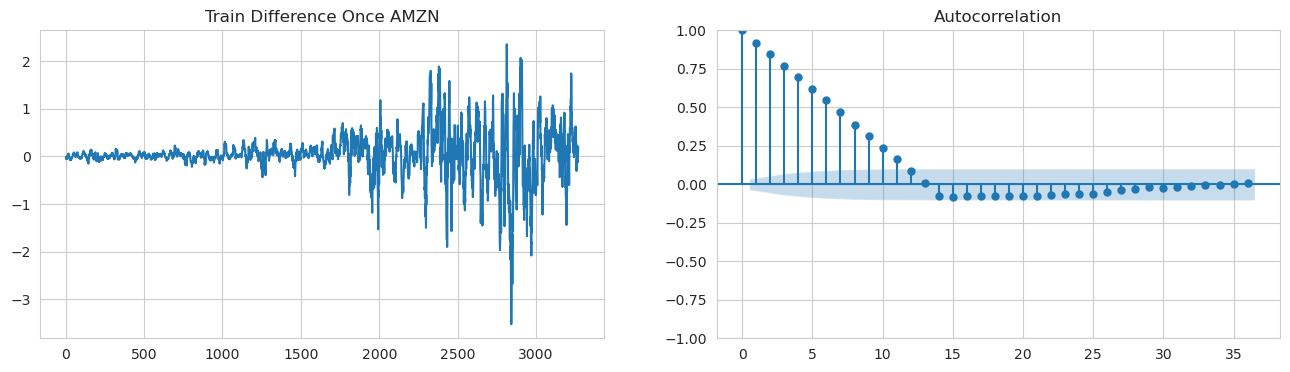

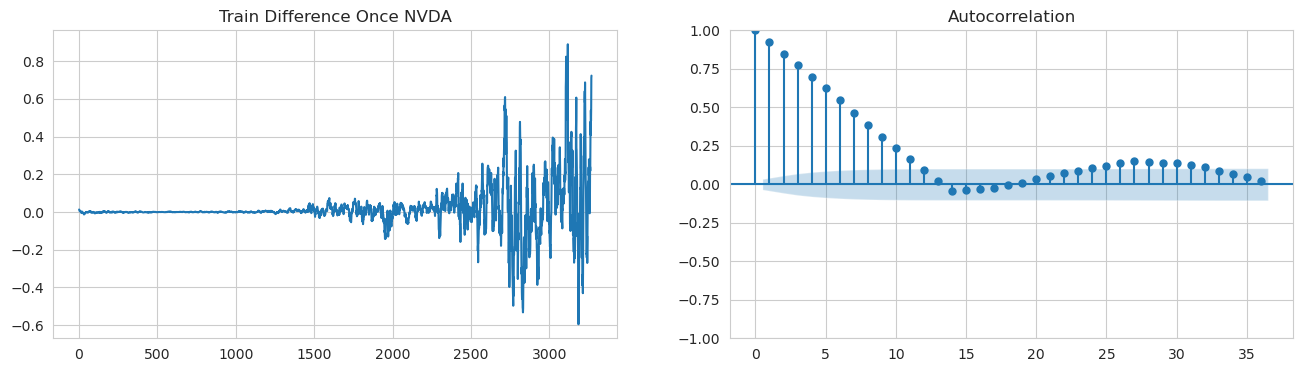

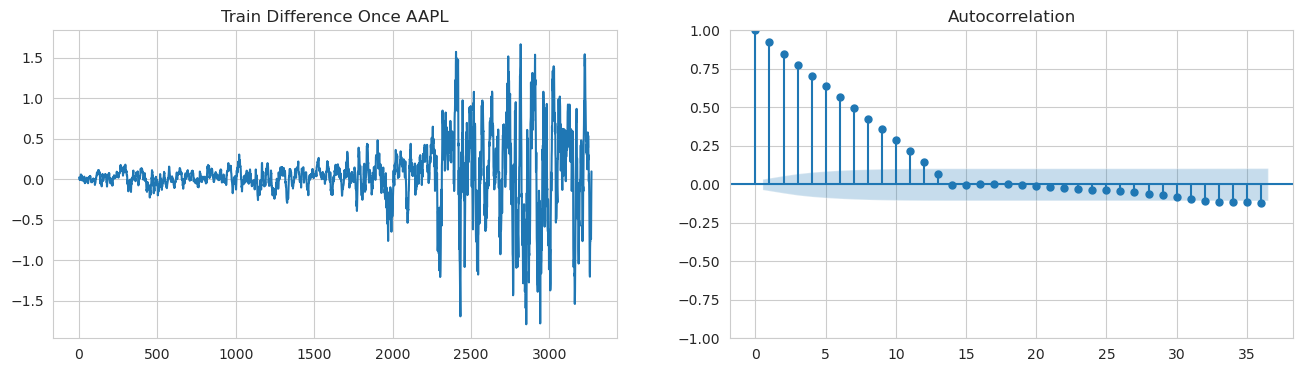

In [108]:
for i in range(len(train)):
    diff1 = train[i].Close.diff().dropna()
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,4))
    ax1.plot(diff1)
    ax1.set_title(f"Train Difference Once {stock_symbols[i]}")
    plot_acf(diff1, ax=ax2);

In [109]:
ndif_train = [ndiffs(train[i].Close, test="adf") for i in range(len(df))]
print("ndif_train", ndif_train)

ndif_train [1, 1, 1, 1, 1]


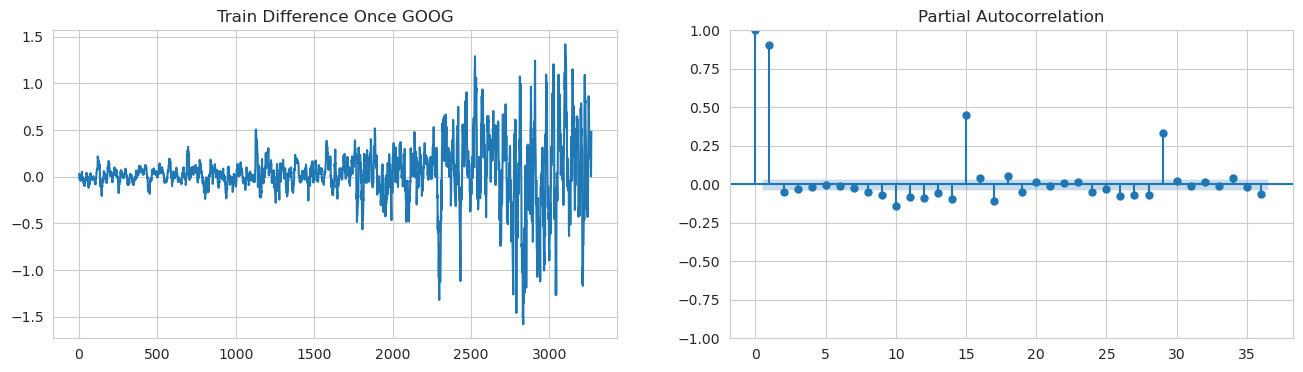

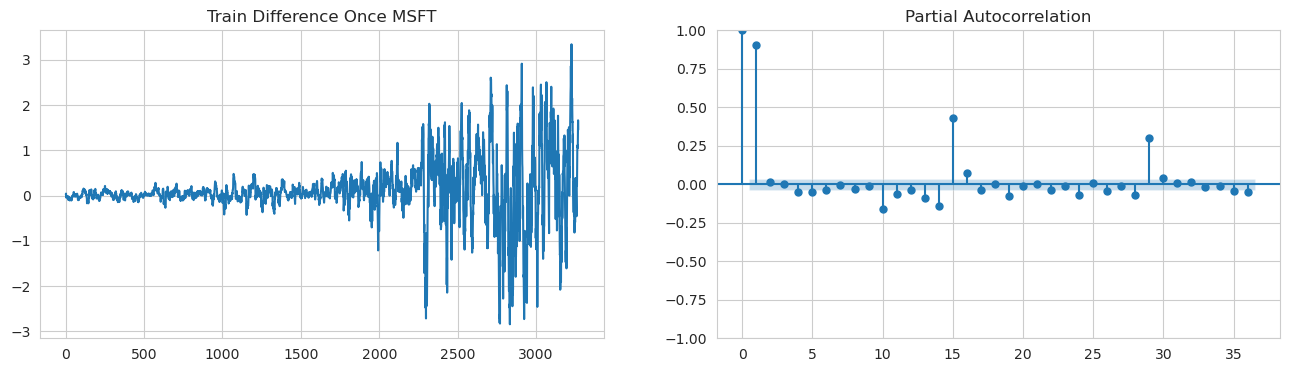

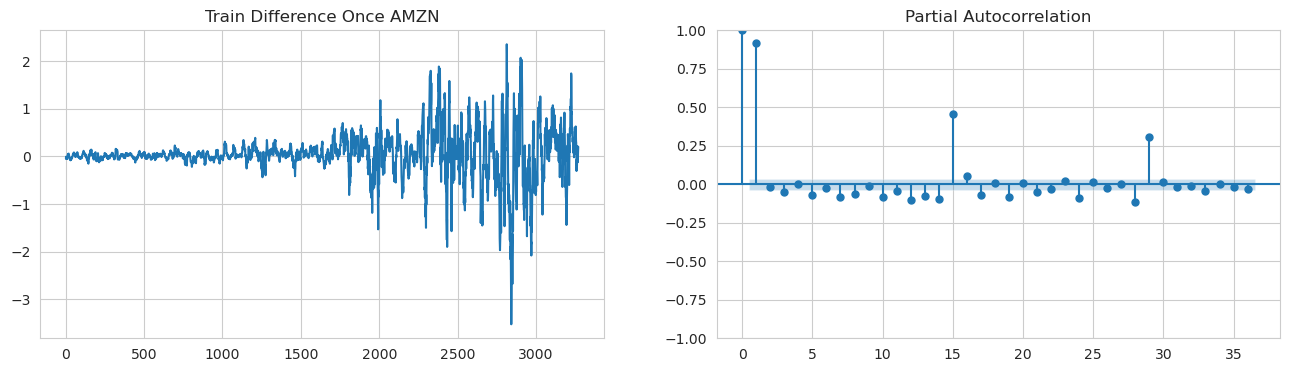

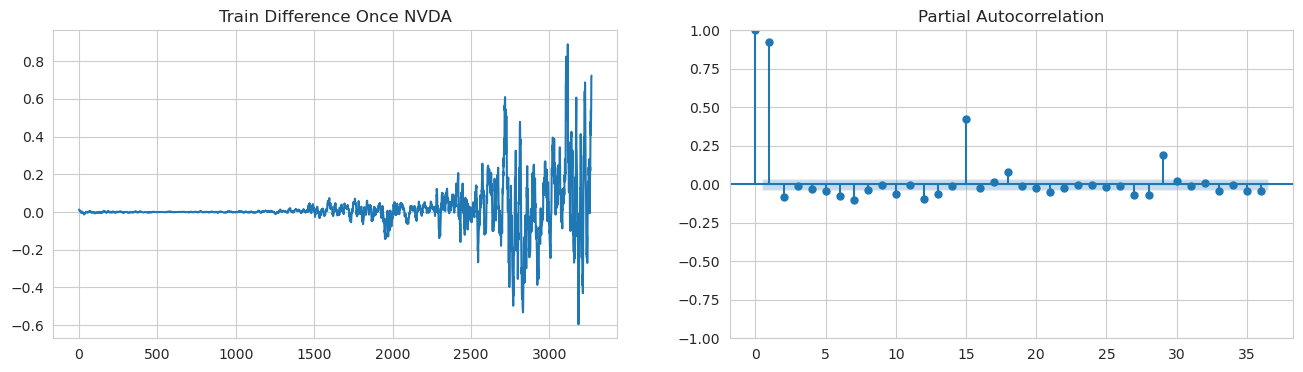

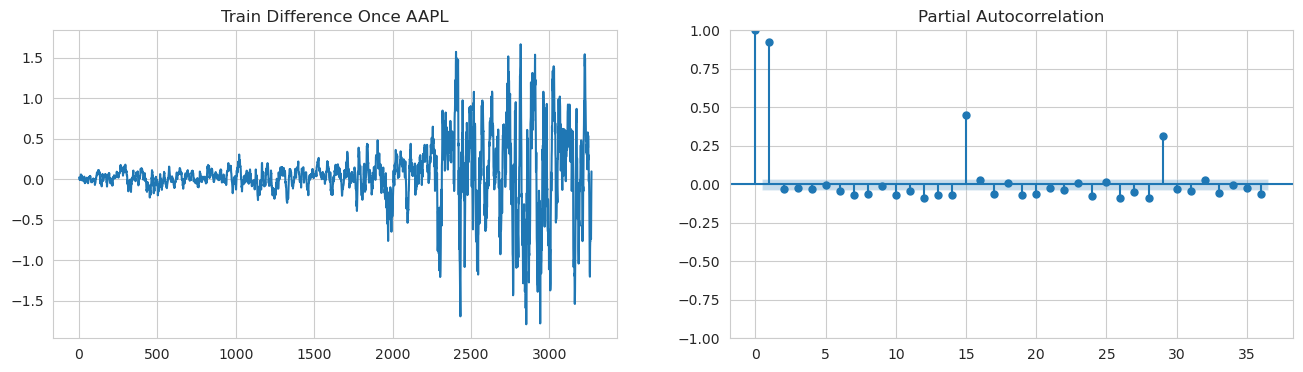

In [110]:
for i in range(len(train)):
    diff1 = train[i].Close.diff().dropna() 
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,4))
    ax1.plot(diff1)
    ax1.set_title(f"Train Difference Once {stock_symbols[i]}")
    plot_pacf(diff1, ax=ax2);

In [19]:
arima_model_train = {}
arima_order_train = {}
for i in range(len(train)):
    print(f"Stock name: {stock_symbols[i]}")
    arima_model_train[i] = auto_arima(train[i].Close, trace=True, exogenous=[train_gss[i]["weighted compound sentiment score"],train_vol[i].Volume])
    arima_order_train[i] = arima_model_train[i].get_params().get("order")
    print(f"Training Set ARIMA Order for {stock_symbols[i]}: {arima_order_train[i]}")

Stock name: GOOG
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4240.062, Time=7.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1459.356, Time=0.53 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4208.998, Time=2.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1332.708, Time=2.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1510.905, Time=0.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4216.735, Time=1.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4242.094, Time=4.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4215.054, Time=1.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4215.655, Time=0.58 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4236.390, Time=7.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4217.382, Time=0.77 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=7.86 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4238.249, Time=1.94 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 38.112 seconds

In [36]:
arima_result_train = {}
for i in range(len(train)):
    model_train = sm.ARIMA(train[i].Close, order=arima_order_train[i] )
    arima_result_train[i] = model_train.fit()
    print(f"\n Training Set ARIMA Results for {stock_symbols[i]}:\n {arima_result_train[i].summary()}")


 Training Set ARIMA Results for GOOG:
                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3270
Model:                 ARIMA(2, 1, 1)   Log Likelihood                2123.125
Date:                Fri, 29 Nov 2024   AIC                          -4238.249
Time:                        18:53:56   BIC                          -4213.880
Sample:                             0   HQIC                         -4229.522
                               - 3270                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8149      0.022     83.252      0.000       1.772       1.858
ar.L2         -0.8323      0.019    -43.055      0.000      -0.870      -0.794
ma.L1       

/home/hirak/anaconda3/envs/SIGNS_2024/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 Training Set ARIMA Results for NVDA:
                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3270
Model:                 ARIMA(2, 2, 2)   Log Likelihood                5739.615
Date:                Fri, 29 Nov 2024   AIC                         -11469.229
Time:                        18:54:08   BIC                         -11438.769
Sample:                             0   HQIC                        -11458.320
                               - 3270                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5818      0.018    -87.915      0.000      -1.617      -1.547
ar.L2         -0.8104      0.018    -44.088      0.000      -0.846      -0.774
ma.L1       

In [131]:
step_30=[30 for i in range(len(df))]
step=[len(test[i]) for i in range(len(df))]
step_30, step

([30, 30, 30, 30, 30], [173, 173, 173, 173, 173])

In [132]:
conf_int_30 = {}
fc_30 = {}
lower_30 = {}
upper_30 = {}
for i in range(len(df)):
    conf_int_30[i] = arima_result_train[i].get_forecast(step_30[i], exog=[train_gss[i]["weighted compound sentiment score"],train_vol[i].Volume]).conf_int(alpha=0.32)
    fc_30[i] = pd.Series(arima_result_train[i].get_forecast(step_30[i], exog=[train_gss[i]["weighted compound sentiment score"],train_vol[i].Volume]).predicted_mean, index = test[i][:step[i]].index)
    # fc_30[i] = pd.Series(arima_result_train[i].predict(step_30[i]), index = test[i][:step_30[i]].index)
    lower_30[i] = pd.Series(conf_int_30[i]['lower Close'], index = test[i][:step_30[i]].index)
    upper_30[i] = pd.Series(conf_int_30[i]['upper Close'], index = test[i][:step_30[i]].index)
    # print(conf_int_30[i])

In [133]:
conf_int = {}
fc = {}
lower = {}
upper = {}
for i in range(len(df)):
    conf_int[i] = arima_result_train[i].get_forecast(step[i], exog=[train_gss[i]["weighted compound sentiment score"],train_vol[i].Volume]).conf_int(alpha=0.32)
    fc[i] = pd.Series(arima_result_train[i].get_forecast(step[i], exog=[train_gss[i]["weighted compound sentiment score"],train_vol[i].Volume]).predicted_mean, index = test[i][:step[i]].index)
    lower[i] = pd.Series(conf_int[i]['lower Close'], index = test[i][:step[i]].index)
    upper[i] = pd.Series(conf_int[i]['upper Close'], index = test[i][:step[i]].index)
    # print(conf_int[i])

In [143]:
arima_result_train[0].get_forecast(10, exog=[train_gss[i]["weighted compound sentiment score"],train_vol[i].Volume]).conf_int(alpha=0.50)

lower Close  upper Close
3270   142.699464   142.869903
3271   142.985511   143.358521
3272   143.207876   143.817958
3273   143.373422   144.245006
3274   143.488176   144.638241
3275   143.557691   144.997414
3276   143.587199   145.323099
3277   143.581647   145.616463
3278   143.545712   145.879097
3279   143.483783   146.112895

In [117]:
test_gss[0]

weighted compound sentiment score
3270                             0.0000
3271                             0.0000
3272                             0.1027
3273                             0.0000
3274                             0.0000
...                                 ...
3438                             0.0000
3439                             0.0000
3440                             0.0000
3441                             0.0000
3442                             0.0000

[173 rows x 1 columns]

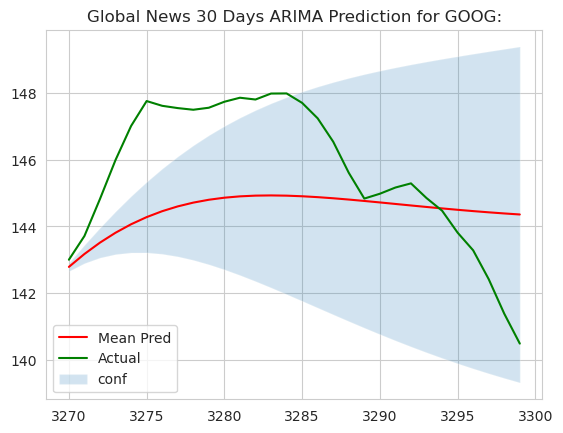

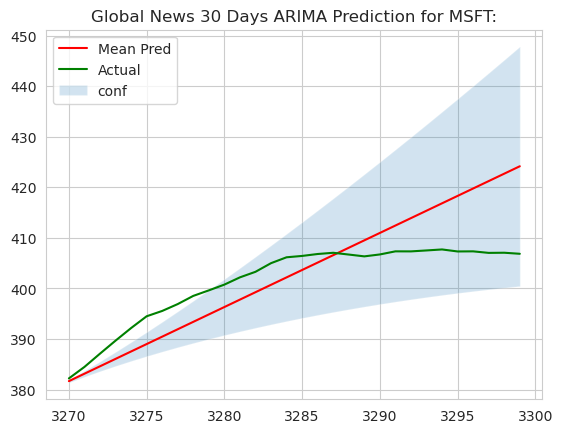

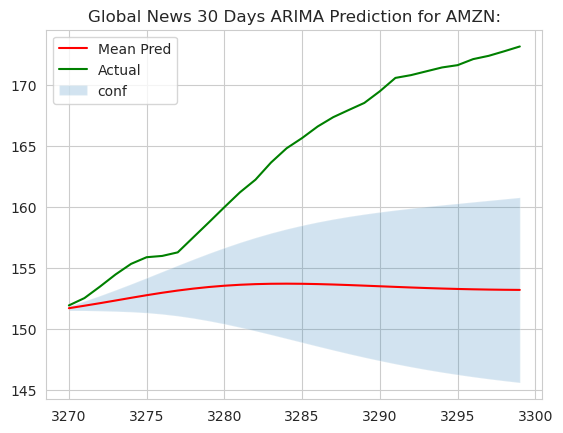

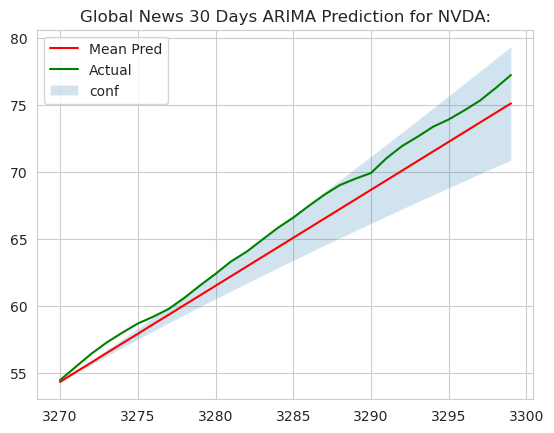

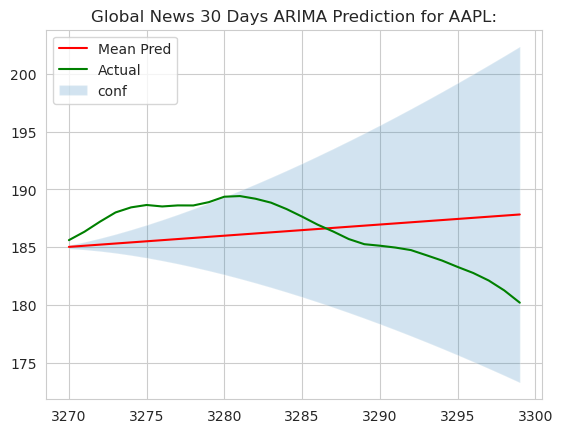

In [136]:
for i in range(len(df)):
    # plt.plot(arima_result_train[i].forecast(step_30[i]), color='r', label='Mean Pred')
    plt.plot(arima_result_train[i].get_forecast(step_30[i], exog=[train_gss[i]["weighted compound sentiment score"],train_vol[i].Volume]).predicted_mean, color='r', label='Mean Pred')
    plt.plot(test[i][:step_30[i]].Close, color='g', label='Actual')
    plt.fill_between(lower_30[i].index, lower_30[i], upper_30[i], alpha = 0.2, label='conf')
    plt.legend()
    plt.title(f"Global News 30 Days ARIMA Prediction for {stock_symbols[i]}:")
    plt.show()

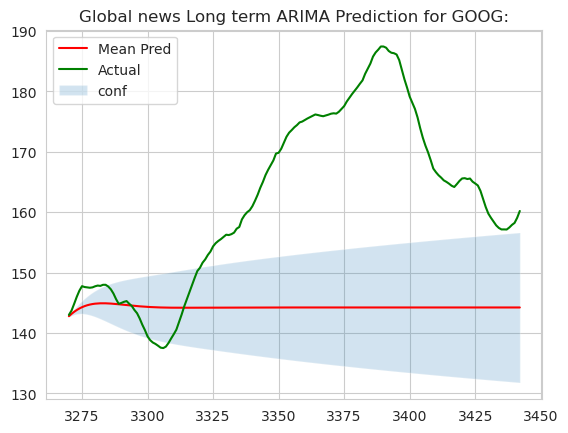

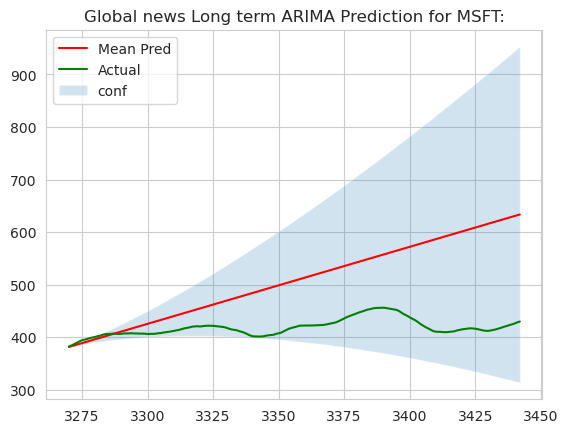

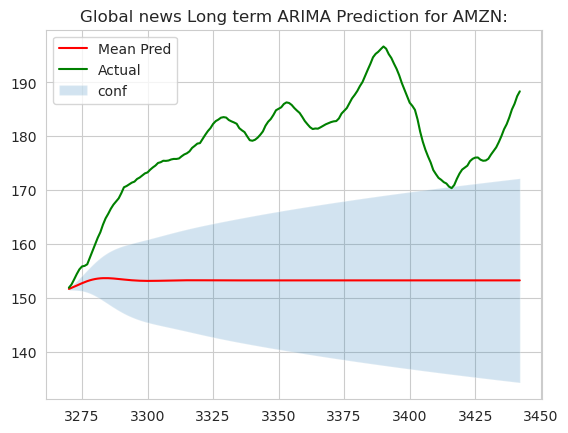

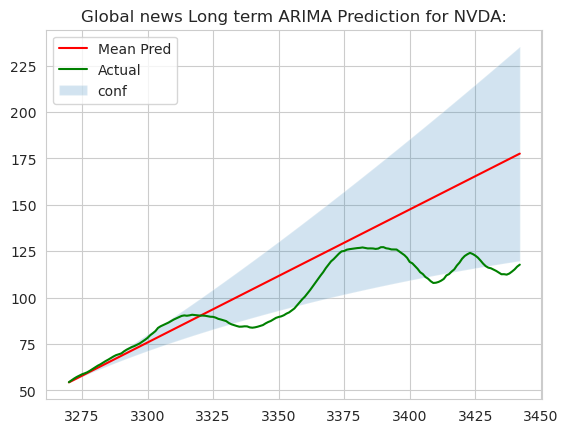

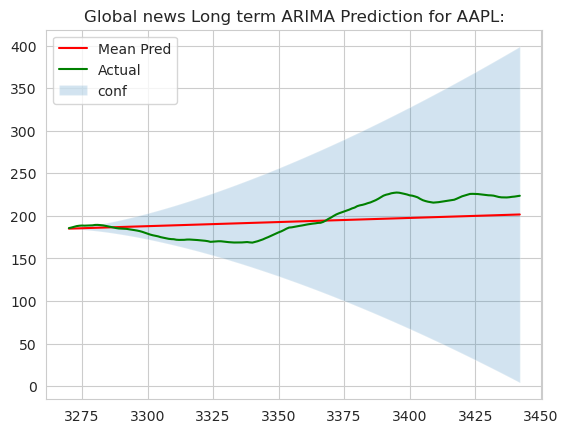

In [137]:
for i in range(len(df)):
    plt.plot(arima_result_train[i].get_forecast(step[i], exog=[train_gss[i]["weighted compound sentiment score"],train_vol[i].Volume]).predicted_mean, color='r', label='Mean Pred')
    plt.plot(test[i][:step[i]].Close, color='g', label='Actual')
    plt.fill_between(lower[i].index, lower[i], upper[i], alpha = 0.2, label='conf')
    plt.legend()
    plt.title(f"Global news Long term ARIMA Prediction for {stock_symbols[i]}:")
    plt.show()

In [138]:
#df_ARIMA_diff = [(train[i].Close - arima_result_train[i].fittedvalues)/(train[i].Close) for i in range(len(df))]
df_ARIMA_diff_30 = [((test[i][:step_30[i]].Close - fc[i][:step_30[i]]))/(test[i][:step_30[i]].Close) for i in range(len(df))]
df_ARIMA_diff = [((test[i][:step[i]].Close - fc[i][:step[i]]))/(test[i][:step[i]].Close) for i in range(len(df))]

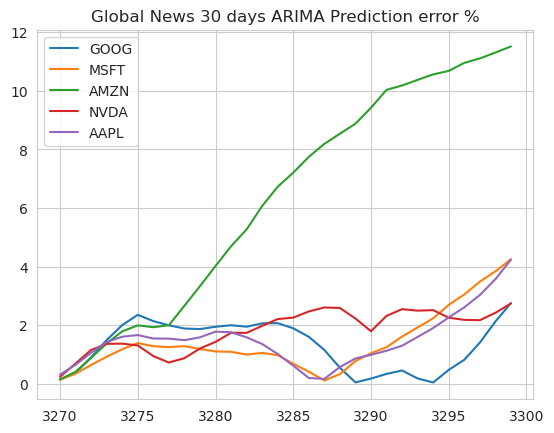

In [139]:
for i in range(len(df)):
    plt.plot(np.abs(df_ARIMA_diff_30[i]*100), label={stock_symbols[i]})
plt.title(f"Global News 30 days ARIMA Prediction error %" , fontsize = 12)
plt.legend()

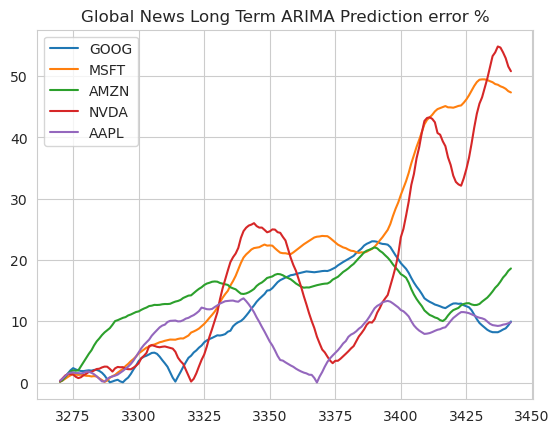

In [140]:
for i in range(len(df)):
    plt.plot(np.abs(df_ARIMA_diff[i]*100), label={stock_symbols[i]})
plt.title(f"Global News Long Term ARIMA Prediction error %" , fontsize = 12)
plt.legend()

In [376]:
df_ARIMA_diff[0]["Change"] = ((test[0][:step[0]].Close - fc[0][:step[0]]))/(test[0][:step[0]].Close)
#df_ARIMA_diff[0]["Change"] = (test[0].Close - arima_result_train[0].fittedvalues)
df_ARIMA_diff[0]['Label'] = (df_ARIMA_diff[0]["Change"] > 0).astype(int)
df_ARIMA_diff[0]['ARIMA_Pred'] = fc[0][:step[0]]

In [377]:
# Drop NaN values
classification_data = df_ARIMA_diff[0]
X = classification_data['ARIMA_Pred']  # Features
y = classification_data['Label']         # Target
print(len(X), len(y))

173 173


In [378]:
X = np.array(X).reshape(-1,1)
y = np.array(y).reshape(-1,1)

In [379]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


/home/hirak/anaconda3/envs/SIGNS_2024/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.9142857142857143
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.90      1.00      0.95        28

    accuracy                           0.91        35
   macro avg       0.95      0.79      0.84        35
weighted avg       0.92      0.91      0.90        35



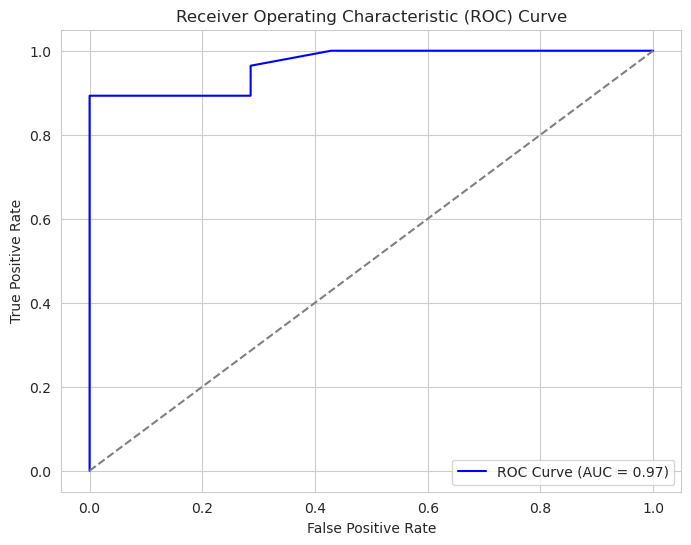

In [380]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
y_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for class 1
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


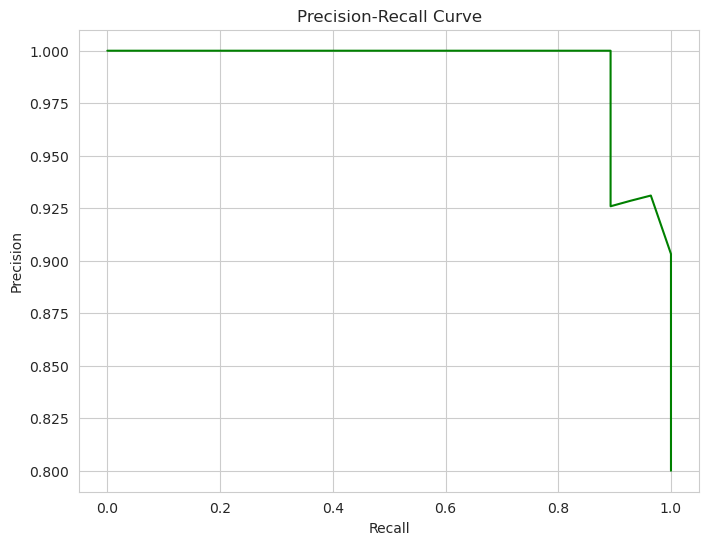

In [381]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


In [41]:
train[0]

Close  arimax_residuals  arimax_fitted
0      15.351314         15.351314       0.000000
1      15.382886          0.031571      15.351316
2      15.396072         -0.015514      15.411587
3      15.401911         -0.005143      15.407054
4      15.374492         -0.031471      15.405963
...          ...               ...            ...
3265  141.131979         -0.040601     141.172580
3266  141.136966         -0.061422     141.198388
3267  141.389915          0.271232     141.118683
3268  141.866601          0.257243     141.609359
3269  142.349701          0.051849     142.297852

[3270 rows x 3 columns]

In [184]:
df_close_sma[1] = df_close_sma[1].drop(['index'], axis=1)
#arima_result_train[0].resid

In [185]:
df_close_sma[1].Close

0        21.823705
1        21.843506
2        21.886410
3        21.889161
4        21.842406
           ...    
3438    423.165002
3439    424.612861
3440    426.307144
3441    428.422143
3442    430.014999
Name: Close, Length: 3443, dtype: float64

In [186]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Extract residuals and fitted values 
df_close_sma[1]['arimax_residuals'] = arima_result[1].resid 
df_close_sma[1]['arimax_fitted'] = arima_result[1].fittedvalues
df_close_sma[1]['gss'] = df_sma_gss[1]['weighted compound sentiment score']
# Combine ARIMAX features with original exogenous variables
X_combined = pd.concat([df_close_sma[1]['gss'], df_close_sma[1].Close, df_close_sma[1][['arimax_residuals', 'arimax_fitted']]], axis=1)
y_combined = df_close_sma[1].Close

#X_combined = X_combined.iloc[1:]
X_combined

gss       Close  arimax_residuals  arimax_fitted
0     0.0   21.823705         21.823705       0.000000
1     0.0   21.843506        -10.892051      32.735557
2     0.0   21.886410          0.023102      21.863308
3     0.0   21.889161         -0.038748      21.927909
4     0.0   21.842406         -0.050910      21.893316
...   ...         ...               ...            ...
3438  0.0  423.165002          0.411031     422.753971
3439  0.0  424.612861         -0.284629     424.897490
3440  0.0  426.307144          0.268720     426.038424
3441  0.0  428.422143          0.407606     428.014537
3442  0.0  430.014999         -0.473017     430.488017

[3443 rows x 4 columns]

In [187]:
features = ['arimax_residuals', 'arimax_fitted']
target = ['Close']
# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=None)

# Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
split_index = int(len(X_combined) * 0.95)
# print(len(df), split_index)
train_data = X_combined.iloc[:split_index]
test_data = X_combined.iloc[split_index:]

# Separate features (X) and target (y)
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Train XGBRegressor
xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=6, random_state=None)
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 2224.02


In [188]:
features_gss = ['gss','arimax_residuals', 'arimax_fitted']
target_gss = ['Close']
# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=None)

# Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
split_index = int(len(X_combined) * 0.95)
# print(len(df), split_index)
train_data = X_combined.iloc[:split_index]
test_data = X_combined.iloc[split_index:]

# Separate features (X) and target (y)
X_train_gss = train_data[features_gss]
y_train_gss = train_data[target_gss]
X_test_gss = test_data[features_gss]
y_test_gss = test_data[target_gss]

# Train XGBRegressor
xgb_model_gss = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=6, random_state=None)
xgb_model_gss.fit(X_train_gss, y_train_gss)

# Evaluate the model
y_pred_gss = xgb_model_gss.predict(X_test_gss)
mse_gss = mean_squared_error(y_test_gss, y_pred_gss)
print(f"Mean Squared Error: {mse_gss:.2f}")




Mean Squared Error: 2208.88


In [91]:
test_data.Close

2779    134.970427
2780    135.224163
2781    135.790379
2782    136.396782
2783    136.664554
           ...    
3265    141.131979
3266    141.136966
3267    141.389915
3268    141.866601
3269    142.349701
Name: Close, Length: 491, dtype: float64

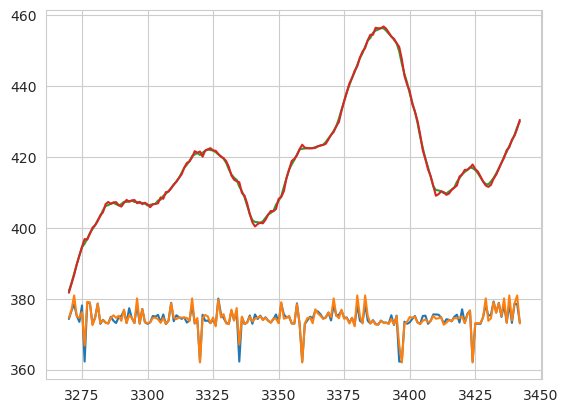

In [189]:
plt.plot(np.array(X_test.index), y_pred)
plt.plot(np.array(X_test.index), y_pred_gss)
plt.plot(np.array(X_test.index), y_test)
plt.plot(np.array(X_test.index), test_data['arimax_fitted'])

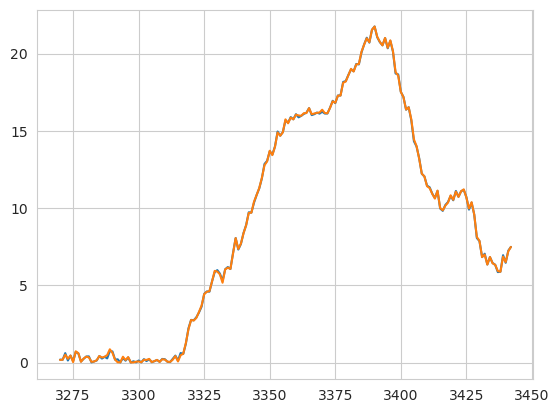

In [151]:
plt.plot(np.array(X_test.index), np.abs(test_data.Close - y_pred)*100/test_data.Close)
plt.plot(np.array(X_test.index), np.abs(test_data.Close - y_pred_gss)*100/test_data.Close)
#plt.plot(np.array(X_test.index), np.abs(test_data.Close - test_data['arimax_fitted'])*100/test_data.Close)